---
title: "Chapter 3, Part 3: Beyond Linear Models"
subtitle: "Machine Learning"
date: "February 2026"
date-format: "MMMM YYYY"
author: 
  - F.San Segundo & N.Rodríguez
bibliography: ../exclude/mlmiin.bib
execute:
  echo: true
code-overflow: wrap
format: 
  html: 
    toc: true
    code-tools: true
    code-fold: show
    code-summary: "Hide the code"
    embed-resources: true
---

---

::: {.callout-warning icon=false}

##### Setting the working directory

We begin by using cd to make sure we are in the right folder.

:::

In [1]:
%cd ./3_3_Beyond_Linear_Models

/wd/3_3_Beyond_Linear_Models


# Session Setup

::: {.callout-note  icon=false}

### Libraries

We begin loading the libraries we will use.

:::



In [2]:
### Load necessary modules -------------------------------
# interactive plotting
# %matplotlib inline
%config InlineBackend.figure_format = 'png' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set()
import statsmodels.api as sm


# Data management libraries
import numpy as np 
import pandas as pd
import scipy.stats as stats

# Machine learning libraries
from sklearn.metrics import root_mean_squared_error 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# Scikit-learn regression models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.inspection import permutation_importance

# Others
import warnings


---

#  Regression models beyond linearity and more comples sklearn pipelines

::: {.callout-note icon=false}

### Extending some already known methods to regression

In this session we will briefly see how to apply in Regression problems some of the methods that we have seen in Classification. We will use an example dataset based on the classic dataset [*Diamonds*](https://www.kaggle.com/datasets/trusepkay/diamonds-csv-updated) for the examples, and we will consider different regression models, that could be any of: 
+ knn, 
+ decision trees 
+ random forests 
+ support vector machines. 
+ gradient boosting

Besides we will use this as an opportunity to introduce more complex preprocessing pipelines in sklearn. This session is heavily inspired by Chapter 2 of the book *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (3rd ed.)* by Aurélien Géron [@Geron2022].

:::

Let us start by loading the dataset and taking a first look at it.

In [3]:
df = pd.read_csv("./diamonds2.csv")
df.head()

carat      cut color clarity  depth  table  price     x     y     z  \
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43   
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31   
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31   
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63   
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75   

   log_price     volume  
0   5.786897  38.202030  
1   5.786897  34.505856  
2   5.789960  38.076885  
3   5.811141  46.724580  
4   5.814131  51.917250

::: {.callout-note icon=false}

### Looking into the type of each variable

+ If we have additional information about the dataset, we can use it to decide which variables are categorical and which are numerical. In this case you can read more about the meaning of each variable in the dataset [here](https://ggplot2.tidyverse.org/reference/diamonds.html) and for the particular version we are using [here](https://www.kaggle.com/datasets/trusepkay/diamonds-csv-updated). Keep in mind though that the dataset has been slightly modified for the purpose of this session.  
</br>

+ In any case, a good practice is to check the number of unique values for each variable.  
   </br>
    + In the case of *numerical variables* if the number of unique values is small, we can consider the variable as categorical (maybe ordinal). If the number of numerical unique values is large, then we most certainly should keep considering the variable as numerical.  
    </br>  
      
    + In the case of *categorical variables* we sometimes need to check if the variable as ordinal. If the number of unique values is large this sometimes can complicate the analysis. In this case we may consider grouping the levels of the variable in some meaningul way (for the purpose of prediction).

:::

In [4]:
df.apply(lambda x: x.nunique())

carat          273
cut              5
color            7
clarity          8
depth          184
table          127
price        11602
x              554
y              552
z              375
log_price    11602
volume       28447
dtype: int64

In this example the above considerations clearly indicate that the variables `cut`, `color` and `clarity` are categorical, while the rest are numerical.

The output variable is the price of the diamond, but we also have the logaritm of the price, which we will use as the output variable in the regression models. In particular we need to drop the `price` variable from the dataset.

::: {.callout-note icon=false}

### Using Standard Names for the variables and dropping unused variables

In order to make our code as reusable as possible for different datasets and problems we have used the same variable names in modeling code. We will see below the benefits of this practice.

We also take this opportunity to **drop the `price` variable from the dataset** before the train/test split. If there is some identifier variable in the dataset, we can also drop it at this point, before entering the preprocessing pipeline. The pipeline can also be used to **drop other variables such as index variables**, but in cases like this there is nothing to be gained by keeping the variable in the pipeline.

:::

In [5]:
num_inputs = ["carat", "depth", "table", "x", "y", "z", "volume"]
cat_inputs = ["cut", "color", "clarity"]

inputs = num_inputs + cat_inputs

output = "log_price"

## Split the dataset into Training and Test Sets  {.unnumbered .unlisted}



::: {.callout-note icon=false}

### Split and Standard Names for the Datasets

The train/test splitting step is a crucial part of the method that we use to assess model performance, and it should be performed as soon as possible in the modeling process. The test set is set aside and must not be used in the model fitting process to avoid *data leakage*.

To ease the model fitting process, we will use the same standard names for the datasets that we have been using in the course:

+ `X` and `Y` are dataframes with the input and output variables, respectively.  
</br>
+ Similarly `XTR`, `YTR`, `XTS`, and `YTS` are the training and test sets for the input and output variables.  
 </br> 
+ dfTR and dfTS are the training and test sets for the whole dataset (including both output and input variables). 

:::

In [6]:
X = df[inputs]
Y = df[output]

XTR, XTS, YTR, YTS = train_test_split(
    X, Y,
    test_size = 0.2,  
    random_state = 1) 

In [7]:
YTS.shape, XTS.shape

((10788,), (10788, 10))

In [8]:
dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR


In [9]:
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS


We end up this initial step by checking the first few rows of `dfTR`.

In [10]:
dfTR.head()

carat  depth  table     x     y     z      volume      cut color  \
42836   0.41   62.3   53.0  4.80  4.77  2.98   68.230080    Ideal     F   
9727    1.12   60.5   59.0  6.79  6.73  4.09  186.899503  Premium     F   
35974   0.42   60.6   56.0  4.83  4.87  2.94   69.154974    Ideal     F   
22501   1.04   62.5   59.0  6.46  6.41  4.02  166.462572  Premium     E   
3571    0.70   58.4   60.0  5.84  5.87  3.42  117.240336     Good     E   

      clarity  log_price  
42836    VVS1   7.212294  
9727      SI2   8.445482  
35974     VS1   6.825460  
22501    VVS1   9.262838  
3571      VS1   8.137103

# EDA

::: {.callout-note icon="false}

### The `describe` and `info` functions.

Your next step is almost always to use these pandas functions. They provide a quick overview of the data, and are a good way to check if the data has been loaded correctly, the types of the variables, and if there are any missing values.

:::

In [11]:
dfTR.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43152 entries, 42836 to 33003
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   carat      43152 non-null  float64
 1   depth      43151 non-null  float64
 2   table      43152 non-null  float64
 3   x          43152 non-null  float64
 4   y          43151 non-null  float64
 5   z          43152 non-null  float64
 6   volume     43152 non-null  float64
 7   cut        43150 non-null  object 
 8   color      43152 non-null  object 
 9   clarity    43150 non-null  object 
 10  log_price  43152 non-null  float64
dtypes: float64(8), object(3)
memory usage: 4.0+ MB


In this example the `Non-Null Count` clearly indicates that there are some missing values in the dataset, a small number. We will deal with them in the preprocessing pipeline below. With `describe` we get a summery of the distribution of the numerical variables.

In [12]:
dfTR.describe()

carat         depth         table             x             y  \
count  43152.000000  43151.000000  43152.000000  43152.000000  43151.000000   
mean       0.797103     61.747183     57.456083      5.727811      5.731675   
std        0.475679      1.431943      2.238037      1.124882      1.152133   
min        0.200000     43.000000     43.000000      0.000000      0.000000   
25%        0.400000     61.000000     56.000000      4.710000      4.720000   
50%        0.700000     61.800000     57.000000      5.690000      5.700000   
75%        1.040000     62.500000     59.000000      6.540000      6.540000   
max        5.010000     79.000000     95.000000     10.740000     58.900000   

                  z        volume     log_price  
count  43152.000000  43152.000000  43152.000000  
mean       3.536817    129.744782      7.783846  
std        0.709894     78.954103      1.016873  
min        0.000000      0.000000      5.786897  
25%        2.910000     64.968744      6.853299  
50%        3.520000    114.524227      7.778211  
75%        4.030000    170.791400      8.580966  
max       31.800000   3840.598060      9.842835

::: {.callout-note icon="false"}

#### Boxplots for the Numerical Inputs

The following code makes boxplots of all the numeric inputs in our example dataset:
:::

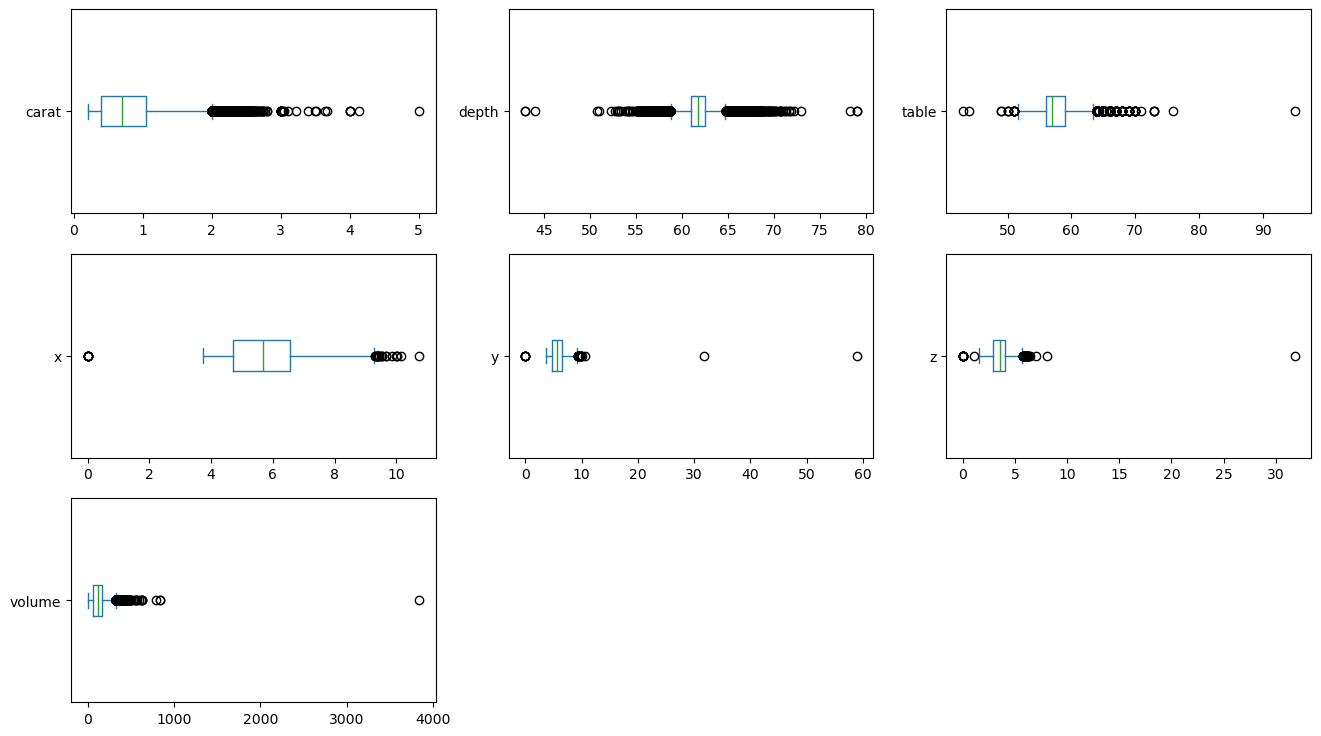

In [13]:
XTR_numeric_boxplots = XTR[num_inputs].plot.box(subplots=True, vert=False,
                                            layout=(len(num_inputs)//3 + len(num_inputs)%3, 3), 
                                            sharex=False, sharey=False, figsize=(16, 4 * len(num_inputs)//3))

+ We see that some of them exhibit a long tail, making it hard to consider all those points as outliers. The lack of symmetry in the distribution of the variables can have an impact on the performance of some models, and we will see how to deal with this in the preprocessing pipeline.

+ Some other inputs show clear isolated outliers. Again, recall that this is just the initial exploration of the data, and we will return to the outliers later in the preprocessing pipeline.

::: {.callout-tip icon="false}

### Exercise 001

Modify this code to use density curves, histograms or violin plots.

::: 

::: {.callout-note icon="false}

### Pairplots

A pairplot for a set of variables $V_1, \ldots, V_j$ is a set of plots arranged in a rectangular (or triangular) grid, describing the distribution and relations between those variables. Here we use [seaborn `pairplot` function](https://seaborn.pydata.org/generated/seaborn.pairplot.html) to draw a pairplot for the numerical inputs.

In the code below you will see that we have added a boolean variable that controls whether to show the pairplot or not. This is a good practice when you are working with large datasets, as plots can be computationally expensive. In general, while doing EDA me tend to make lots of plots, but we only keep the most informative ones for our final report and conclusions. And since we will be cycling around the preprocessing pipeline and rerunning the code, it is often convenient to have a way to turn off the plots.

:::

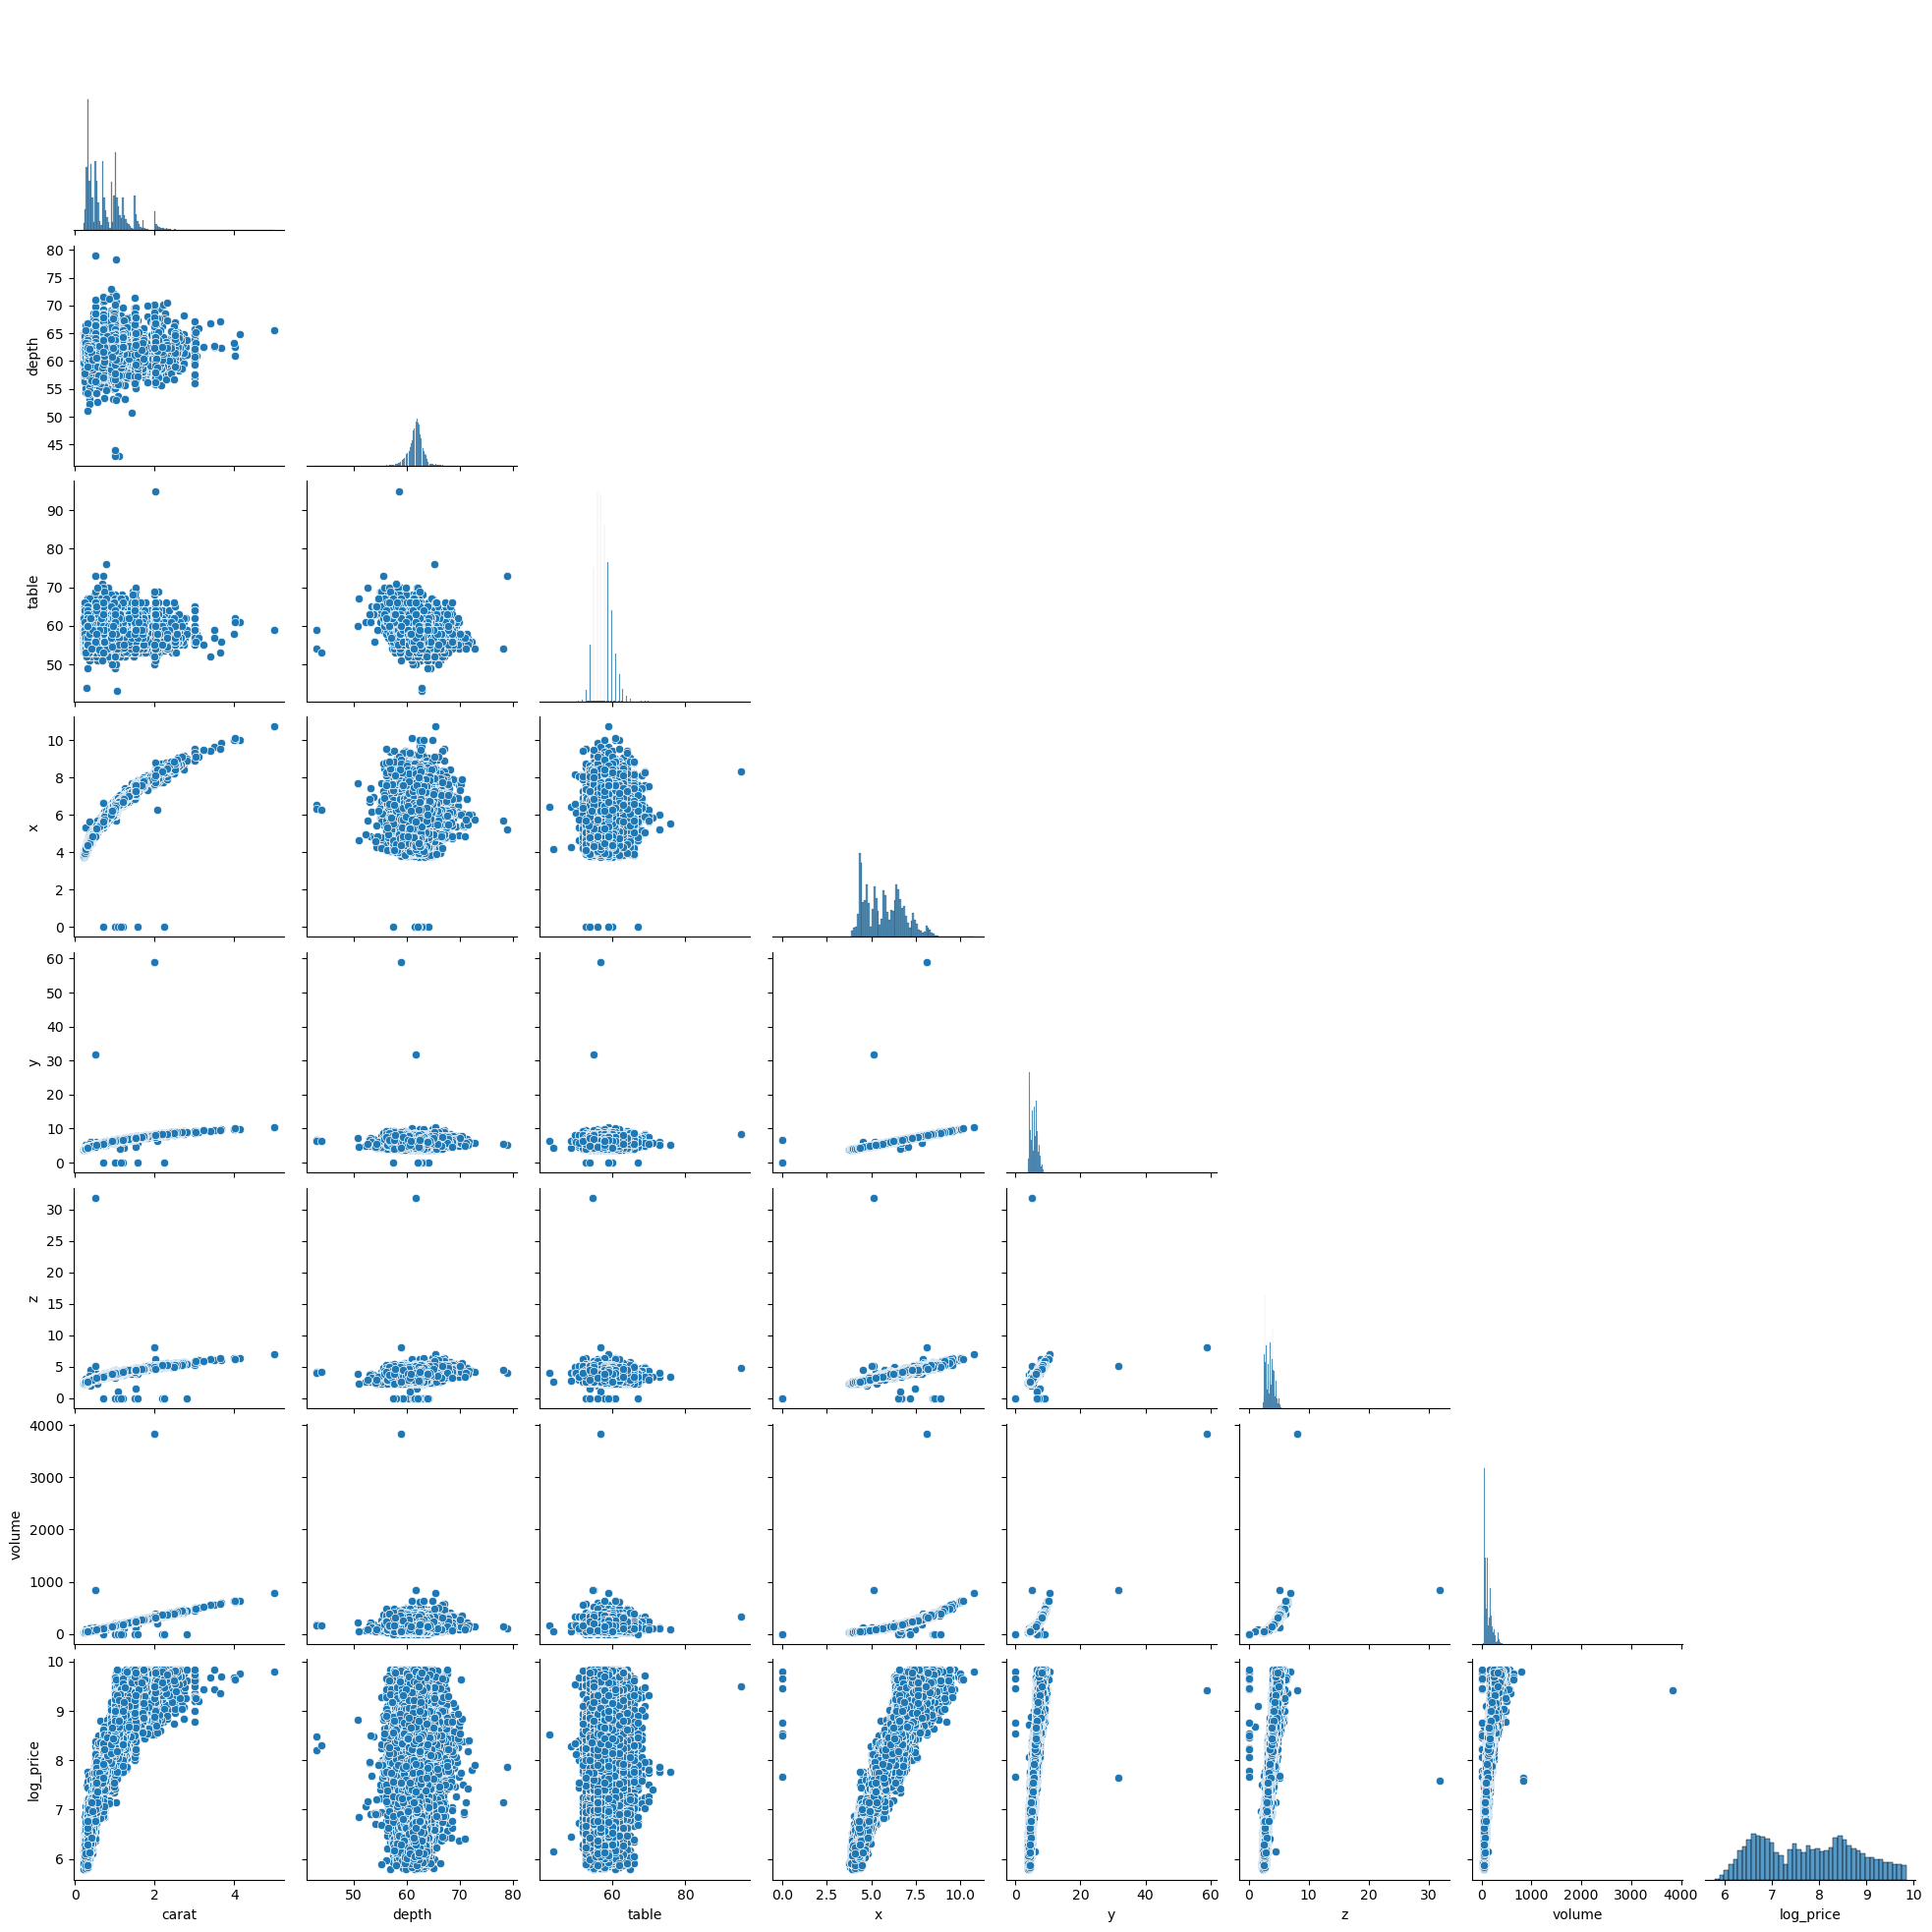

In [14]:
show_pairplot = True
if show_pairplot:
    sns.pairplot(dfTR[num_inputs+[output]].sample(frac=1), corner=True)

The most relevant messages out of this pairplot are:

- there are **obvious outliers** in some of the variables, we will need to address this issue before fitting the models.  

- We have some **highly correlated inputs**, we will need to address collinearity before fitting the models.  

- Some inputs show a **clear and non-linear relationship with the target variable**, we will need to consider non-linear models or add polynomial terms to the model.

::: {.callout-note icon="false}

### Plots to Study Numerical Input vs Factor Input Relations

The following code will plot parallel boxplots for each combination of a numerical input and a factor input. This information is useful for feature selection and engineering.
:::

In [15]:
show_parallel_boxplots = False

if show_parallel_boxplots: 
    if len(cat_inputs) > 1:
        print("More than one factor input, creating parallel boxplots for each factor input")
    for numVar in num_inputs + [output]: 
        catvar_num = 0
        if len(cat_inputs) > 1:
            plt.figure(figsize=(12, 1))
            fig, axes = plt.subplots(1, len(cat_inputs))  # create figure and axes
            print("------------"*10)
            print(f"Analyzing the relation between {numVar} and the factor inputs; {cat_inputs}")
            for col, ax in zip(cat_inputs, axes):  # boxplot for each factor inpput            
                catvar_num += 1
                sns.boxplot(data=dfTR, x = col, y = numVar, ax=ax) 
                ax.tick_params(axis='x', rotation=45, labelsize=8)  # Rotate and resize x-axis labels            
            # set subplot margins
            plt.subplots_adjust(left=0.9, bottom=0.4, right=2, top=1, wspace=1, hspace=1)
            plt.show();plt.close();
        else:
            print(f"Analyzing the relation between {numVar} and the factor input {cat_inputs[0]}")
            sns.boxplot(data=dfTR, x = cat_inputs[0], y = numVar)
            plt.show();plt.close();


In the diamonds dataset the above boxplots show that the the cut, color, and clarity of the diamond do not seem to be strongly related to the price of the diamond.

Besides, there is also no clear strong relationships between those factors and the numerical input variables. For now, in this initial exploratory step we keep all the variables for the regression analysis, and we will let the preprocessing steps below decide if we need to remove some of them.

## Outliers and beginning the preprocessing pipeline

::: {.callout-note  icon=false}

### Dealing with outliers.

In previous sessions we have already dealt with outliers in the dataset simply by removing them. Here we provide a function to do that automatically for all the numerical variables in the dataset, based on a threshold that we can set.

:::


::: {.callout-warning icon=false}

### Outliers vs NAs: what should we do first?

If you have a dataset with outliers and missing values, you have to decide which to deal with first. In general, the answer depends on whether you are planning to drop or impute the missing values. If you are going to impute the missing values, you should drop the outliers first, as their presence can severely distort the imputation process. If you are going to drop the missing values, you can do it first, as the presence of missing values can affect the outlier detection process. Since we are going to try impuation in the preprocessing pipeline, we will drop the outliers first.

:::

Note that the code below takes the above warning into account, and it uses numpy's functions starting with `nan` that are designed to handle missing values. For example, `np.nanpercentile` will ignore missing values when calculating the percentiles.



In [16]:
def remove_outliers(X, method="iqr", threshold=1.5):
    if isinstance(X, pd.DataFrame):
        X = X.copy()  # Avoid modifying the original DataFrame
        columns = X.columns  # Save column names
        idx = X.index  # Save row index
        X_values = X.values  # Work on raw numpy array

    else:
        return X  # If not a DataFrame, return as is

    if method == "iqr":
        Q1 = np.nanpercentile(X_values, 25, axis=0)
        Q3 = np.nanpercentile(X_values, 75, axis=0)
        IQR = Q3 - Q1
        mask = (X_values >= Q1 - threshold * IQR) & (X_values <= Q3 + threshold * IQR)
    elif method == "std":
        mean = np.nanmean(X_values, axis=0)
        std = np.nanstd(X_values, axis=0)
        mask = (X_values >= mean - threshold * std) & (X_values <= mean + threshold * std)
    else:
        return X  # If the method is not valid, return without changes

    X_values = np.where(mask, X_values, np.nan)  # Convert outliers to NaN
    return pd.DataFrame(X_values, columns=columns, index=idx)  # Convert back to DataFrame


::: {.callout-note  icon=false}

### Outlier removal transformer with boolean hyperparameter

We now take the first step in building the preprocessing pipeline. We will use a scikit `Transformer` to apply the outlier removal function to the numerical variables in the dataset. We will also use a boolean hyperparameter to control whether to remove the outliers or not. This is a good practice, because it lets you experiment with different preprocessing strategies with minimal code changes, or explore this strategies in a grid search.

:::


In [17]:
def create_outlier_transformer(threshold=1.5, method="iqr", use_outlier_removal = True):
    if use_outlier_removal:
         return FunctionTransformer(lambda X: remove_outliers(X, method=method, threshold=threshold))
    else:
        return FunctionTransformer(lambda X: X)

# Create the transformer with an initial threshold
outlier_remover = create_outlier_transformer(threshold=1.5, use_outlier_removal = True)
outlier_remover.set_output(transform='pandas')


FunctionTransformer(func=<function create_outlier_transformer.<locals>.<lambda> at 0x7cc4f911eac0>)

::: {.callout-note  icon=false}

### Column transformer

Outlier removal is only meant for numerical variables. In our pipelines we use a `ColumnTransformer` whenever we need to apply different transformations to different subsets of the variables. In this case we will use the `ColumnTransformer` to apply the outlier removal to the numerical variables only, and the rest of the variables will be passed through unchanged thanks to the `remainder='passthrough'` argument.

We include `force_int_remainder_cols=False` to avoid a scikit's ~~nagging~~ warning about a future change in the default behavior of the `ColumnTransformer`.

:::


In [18]:
outlier_removal = ColumnTransformer(
    transformers=[("outlier_remover", outlier_remover, num_inputs)],
    remainder="passthrough", 
    force_int_remainder_cols=False)
outlier_removal.set_output(transform='pandas')

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('outlier_remover',
                                 FunctionTransformer(func=<function create_outlier_transformer.<locals>.<lambda> at 0x7cc4f911eac0>),
                                 ['carat', 'depth', 'table', 'x', 'y', 'z',
                                  'volume'])])

::: {.callout-note  icon=false}

### Pipeline and the issue of Scikit naming conventions

With this we are ready to start constructing a preprocessing pipeline. As you will see we will do this incrementally, adding transformers one by one. This is a good practice, as it allows you to check the intermediate results and debug the pipeline more easily. We will also make sure that the output of the pipeline remains a pandas dataframe and that the changes in the name variables are kept to a minimum and are controlled by us. Scikit has a bad habit of changing the names of the variables without letting you control those changes. We will illustrate this below.

:::


In [19]:
preproc_pipeline = Pipeline([
    ("remove_outliers", outlier_removal)
])

preproc_pipeline.set_output(transform='pandas')

Pipeline(steps=[('remove_outliers',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('outlier_remover',
                                                  FunctionTransformer(func=<function create_outlier_transformer.<locals>.<lambda> at 0x7cc4f911eac0>),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z',
                                                   'volume'])]))])

A nice thing about this incremental pipelines is that you can run them step by step and check the intermediate results. For example, we can check the first few rows of the dataset after the outlier removal step. Note that we use XTR here to avoid involving the output variable.

In [20]:
preproc_pipeline.fit_transform(XTR)

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


outlier_remover__carat  outlier_remover__depth  outlier_remover__table  \
42836                    0.41                    62.3                    53.0   
9727                     1.12                    60.5                    59.0   
35974                    0.42                    60.6                    56.0   
22501                    1.04                    62.5                    59.0   
3571                     0.70                     NaN                    60.0   
...                       ...                     ...                     ...   
50057                    0.70                    62.8                    59.0   
32511                    0.40                    63.9                    57.0   
5192                     0.91                    62.7                    63.0   
12172                    1.18                    61.7                    56.0   
33003                    0.32                    60.9                    56.0   

       outlier_remover__x  outlier_remover__y  outlier_remover__z  \
42836                4.80                4.77                2.98   
9727                 6.79                6.73                4.09   
35974                4.83                4.87                2.94   
22501                6.46                6.41                4.02   
3571                 5.84                5.87                3.42   
...                   ...                 ...                 ...   
50057                5.56                5.61                3.51   
32511                4.71                4.65                2.99   
5192                 6.05                6.00                3.78   
12172                6.79                6.82                4.20   
33003                4.41                4.43                2.69   

       outlier_remover__volume remainder__cut remainder__color  \
42836                68.230080          Ideal                F   
9727                186.899503        Premium                F   
35974                69.154974          Ideal                F   
22501               166.462572        Premium                E   
3571                117.240336           Good                E   
...                        ...            ...              ...   
50057               109.482516      Very Good                I   
32511                65.485485           Good                E   
5192                137.214000      Very Good                G   
12172               194.492760          Ideal                J   
33003                52.552647          Ideal                E   

      remainder__clarity  
42836               VVS1  
9727                 SI2  
35974                VS1  
22501               VVS1  
3571                 VS1  
...                  ...  
50057                VS2  
32511                SI2  
5192                 VS2  
12172                VS1  
33003               VVS1  

[43152 rows x 10 columns]

::: {.callout-note  icon=false}

### Restoring the original names of the variables

As you can see in this example (and in previous course sessions) the names of the variables are changed by the transformers in the pipeline. This is a common issue in scikit, and it is a common source of errors and difficulties (besides being plain annoying!) 

To avoid this issue we are going to use a custom transformer that will restore the original names of the variables. It is defined in the cell below. You can also use this is as an opportunity to dive a little deeper into Python's object oriented programming. The books [@Geron2022] and [@Raschka2022] can help you learn how Python's oop is used in Machine Learning with scikit. If you need a thorough introduction to Python's oop, you can check the books that appear in the [further reading](#further-reading) section below.

:::


In [21]:
class ColumnNameCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, separator="__"):
        self.separator = separator
        self._output_format = 'pandas'  # Default output format


    def fit(self, X, y=None):
        return self  # Nothing to learn, just transforming

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            # Remove prefix up to the separator "__"
            new_columns = [col.split(self.separator, 1)[-1] if self.separator in col else col for col in X.columns]
            X = X.copy()
            X.columns = new_columns
        return X

    def set_output(self, transform='pandas'):
        """Allows the user to choose the output format for the transformer."""
        if transform not in ['array', 'pandas']:
            raise ValueError("Output format must be 'array' or 'pandas'")
        self._output_format = transform

In [22]:
preproc_pipeline.fit_transform(XTR)

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


outlier_remover__carat  outlier_remover__depth  outlier_remover__table  \
42836                    0.41                    62.3                    53.0   
9727                     1.12                    60.5                    59.0   
35974                    0.42                    60.6                    56.0   
22501                    1.04                    62.5                    59.0   
3571                     0.70                     NaN                    60.0   
...                       ...                     ...                     ...   
50057                    0.70                    62.8                    59.0   
32511                    0.40                    63.9                    57.0   
5192                     0.91                    62.7                    63.0   
12172                    1.18                    61.7                    56.0   
33003                    0.32                    60.9                    56.0   

       outlier_remover__x  outlier_remover__y  outlier_remover__z  \
42836                4.80                4.77                2.98   
9727                 6.79                6.73                4.09   
35974                4.83                4.87                2.94   
22501                6.46                6.41                4.02   
3571                 5.84                5.87                3.42   
...                   ...                 ...                 ...   
50057                5.56                5.61                3.51   
32511                4.71                4.65                2.99   
5192                 6.05                6.00                3.78   
12172                6.79                6.82                4.20   
33003                4.41                4.43                2.69   

       outlier_remover__volume remainder__cut remainder__color  \
42836                68.230080          Ideal                F   
9727                186.899503        Premium                F   
35974                69.154974          Ideal                F   
22501               166.462572        Premium                E   
3571                117.240336           Good                E   
...                        ...            ...              ...   
50057               109.482516      Very Good                I   
32511                65.485485           Good                E   
5192                137.214000      Very Good                G   
12172               194.492760          Ideal                J   
33003                52.552647          Ideal                E   

      remainder__clarity  
42836               VVS1  
9727                 SI2  
35974                VS1  
22501               VVS1  
3571                 VS1  
...                  ...  
50057                VS2  
32511                SI2  
5192                 VS2  
12172                VS1  
33003               VVS1  

[43152 rows x 10 columns]

::: {.callout-note  icon=false}

### Incremental pipeline construction

We will have to reuse the above custom transformer quite a few times in the next steps of the pipeline. And it gives us our first example of how to update the preprocessing pipeline with new steps. 

:::


In [23]:
new_step = ("outliers_name_cleanup", ColumnNameCleaner())
preproc_pipeline = Pipeline(preproc_pipeline.steps + [new_step])
preproc_pipeline

Pipeline(steps=[('remove_outliers',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('outlier_remover',
                                                  FunctionTransformer(func=<function create_outlier_transformer.<locals>.<lambda> at 0x7cc4f911eac0>),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z',
                                                   'volume'])])),
                ('outliers_name_cleanup', ColumnNameCleaner())])

::: {.callout-note  icon=false}

### Check the results of the pipeline

Thanks to the incremental construction of the pipeline, we can check the results of each step in the pipeline using the code in the next cell (the same code can be used after every update).

:::

In this case, as you can see, the names of the variables have been restored to their original values.


In [24]:
preproc_pipeline.fit_transform(XTR)

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


carat  depth  table     x     y     z      volume        cut color  \
42836   0.41   62.3   53.0  4.80  4.77  2.98   68.230080      Ideal     F   
9727    1.12   60.5   59.0  6.79  6.73  4.09  186.899503    Premium     F   
35974   0.42   60.6   56.0  4.83  4.87  2.94   69.154974      Ideal     F   
22501   1.04   62.5   59.0  6.46  6.41  4.02  166.462572    Premium     E   
3571    0.70    NaN   60.0  5.84  5.87  3.42  117.240336       Good     E   
...      ...    ...    ...   ...   ...   ...         ...        ...   ...   
50057   0.70   62.8   59.0  5.56  5.61  3.51  109.482516  Very Good     I   
32511   0.40   63.9   57.0  4.71  4.65  2.99   65.485485       Good     E   
5192    0.91   62.7   63.0  6.05  6.00  3.78  137.214000  Very Good     G   
12172   1.18   61.7   56.0  6.79  6.82  4.20  194.492760      Ideal     J   
33003   0.32   60.9   56.0  4.41  4.43  2.69   52.552647      Ideal     E   

      clarity  
42836    VVS1  
9727      SI2  
35974     VS1  
22501    VVS1  
3571      VS1  
...       ...  
50057     VS2  
32511     SI2  
5192      VS2  
12172     VS1  
33003    VVS1  

[43152 rows x 10 columns]

And furthermore, we can check that the outliers have been removed from the numerical variables with a new pairplot (compare it with the previous one).

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


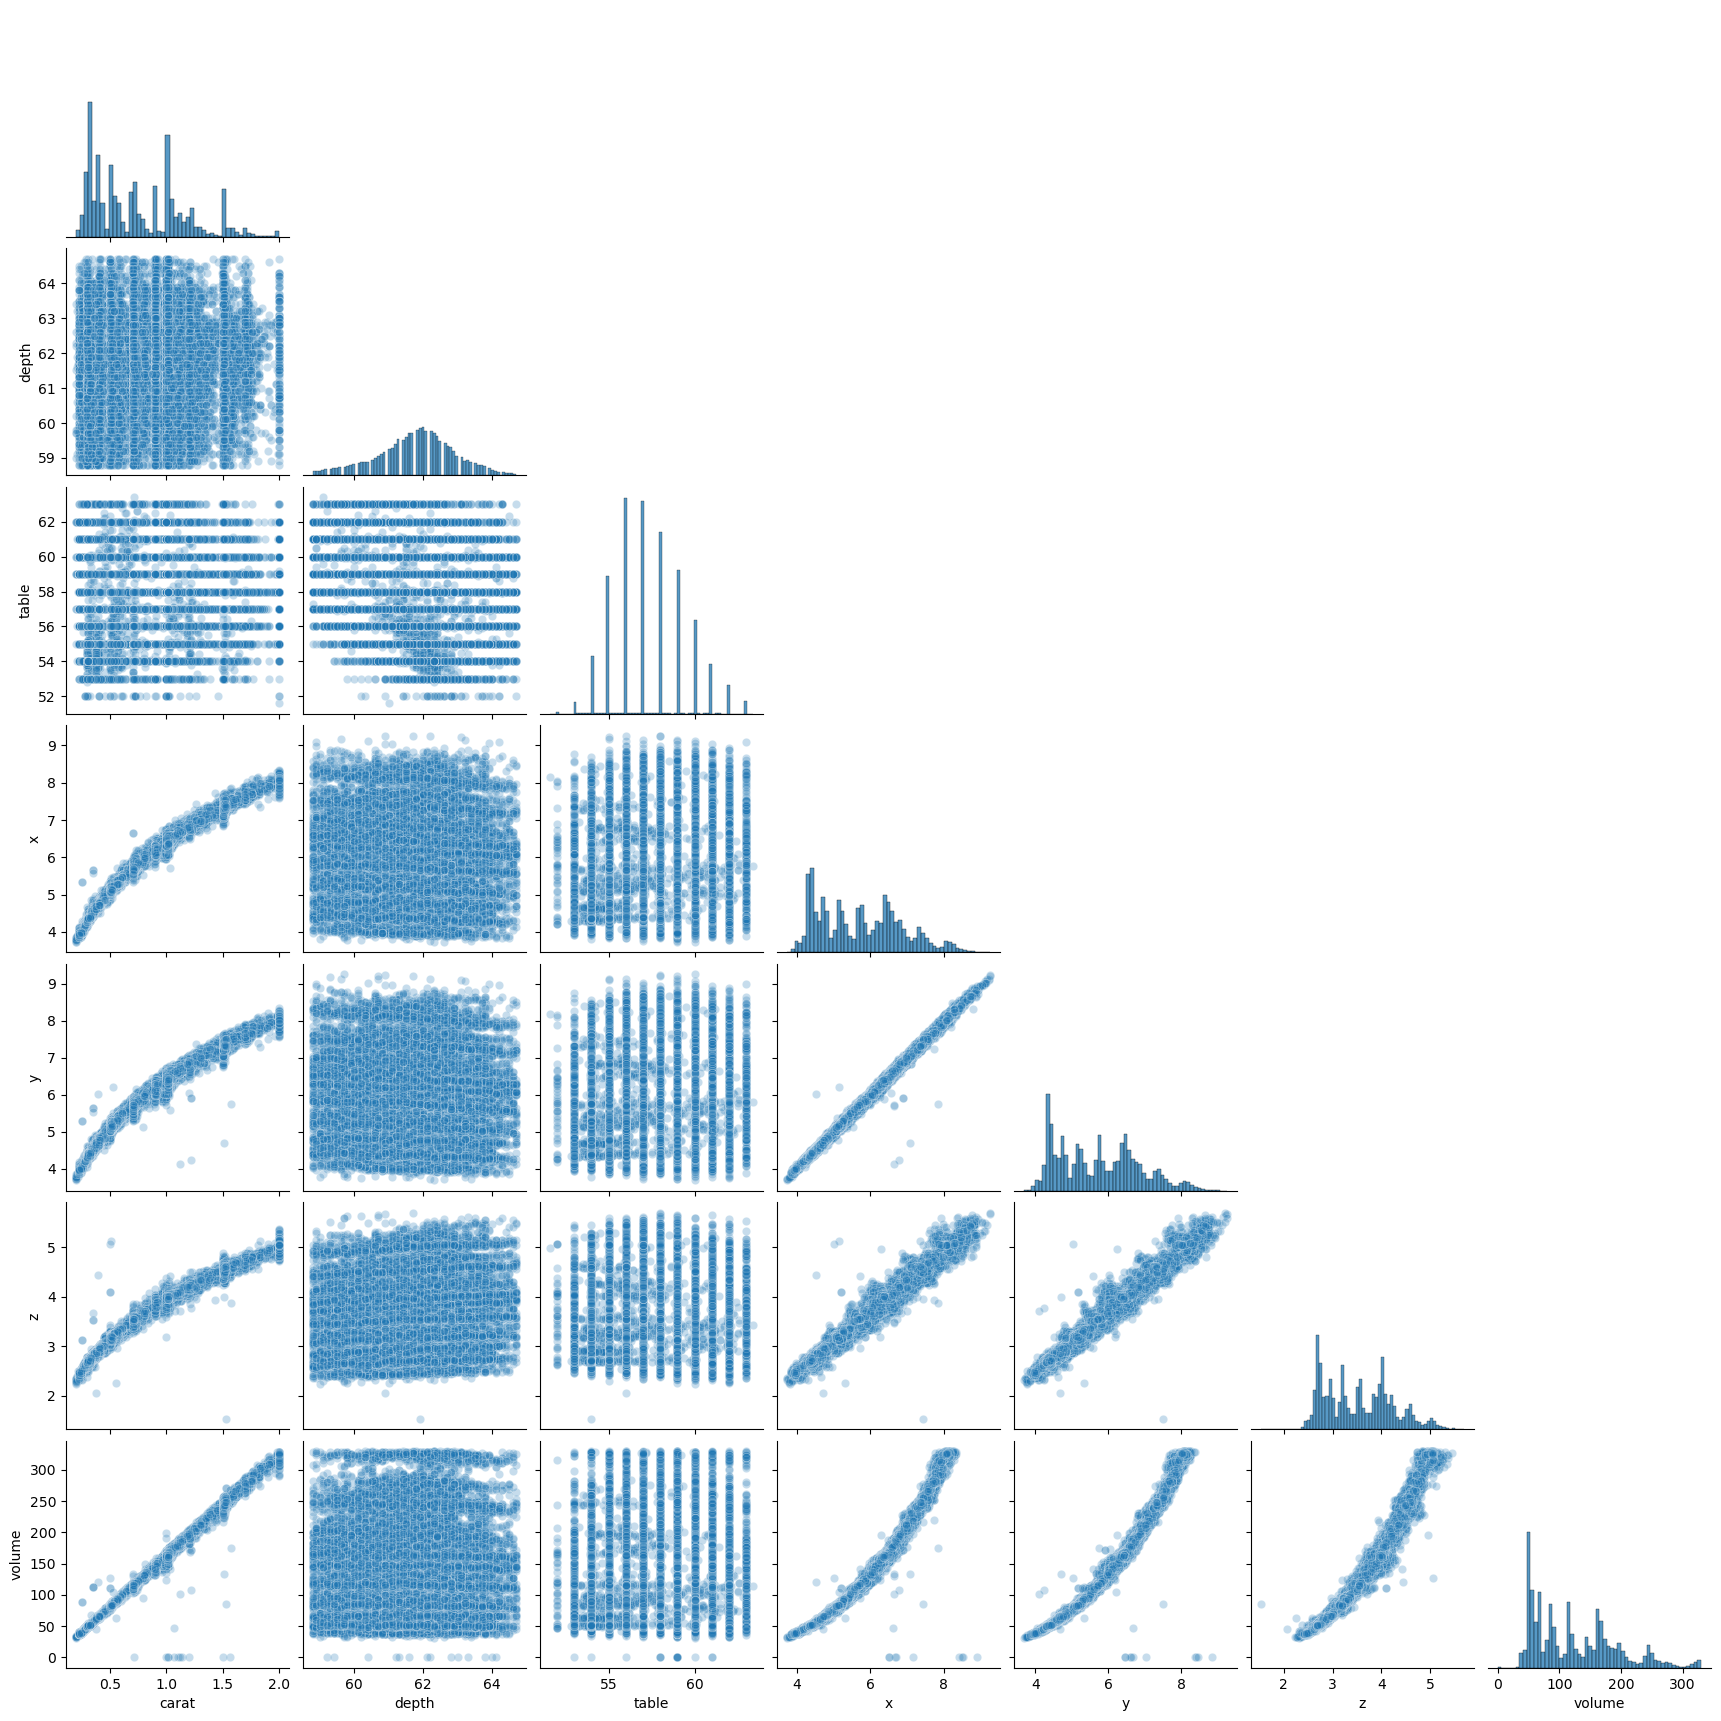

In [25]:
show_pairplot2 = True
if show_pairplot2:
    sns.pairplot(preproc_pipeline.fit_transform(dfTR)[num_inputs], plot_kws={'alpha': 0.25}, corner=True)

::: {.callout-note  icon=false}

### An alternative: winsorizing

In previous sessions we have dealt with outliers in the dataset simply by removing them. This is a common practice, but it is not always the best one. We can instead use imputation methods to replace the outliers with values that are more representative of the distribution of the variable. For example we can use the [`Winsorizer`](https://feature-engine.trainindata.com/en/1.8.x/user_guide/outliers/Winsorizer.html) transformer from the `feature-engine` package. This transformer will replace the outliers with the maximum or minimum value of the variable, depending on the side of the distribution where the outlier is located.

:::


## Dealing with missing values.  Imputation methods.


::: {.callout-note  icon=false}

### Imputation methods

Now that the outliers have been taken care of, we can proceed to impute the missing values in the dataset. There are many imputation methods. In this example we will use the `SimpleImputer` from scikit, which is a simple method that replaces missing values with the mean, median, or most frequent value of the variable.

First let us check the number of missing values for each variable in the dataset. Note that we have missing values in both numerical and categorical variables.

:::


In [26]:
dfTR.isna().sum(axis=0)

carat        0
depth        1
table        0
x            0
y            1
z            0
volume       0
cut          2
color        0
clarity      2
log_price    0
dtype: int64

::: {.callout-warning icon=false}

### NAs in the output variable

Fortunately, in this example there are no missing values in the output variable. And there is a good reason for that in most Machine Learning datasets. In general it is not a good idea to impute missing values in the output variable. If you have missing values in the output variable, you should remove those rows from the dataset as the imputation process can severely bias the model fitting process. 

:::

::: {.callout-note  icon=false}

### Implementing the SimpleImputer

The `SimpleImputer` has a `strategy` argument that can be set to `'mean'`, `'median'`, or `'most_frequent'`. We will use the `'mean'` strategy for the numerical variables and the `'most_frequent'` strategy for the categorical variables. That means that we will have to use two `SimpleImputer` transformers in the pipeline and combine them with a `ColumnTransformer`. And in turn that means that we need to use our variable name restoration transformer again.

:::


In [27]:
from sklearn.impute import SimpleImputer

num_imputer = (SimpleImputer(strategy="median"))
num_imputer.set_output(transform='pandas')

cat_imputer = SimpleImputer(strategy="most_frequent")
cat_imputer.set_output(transform='pandas')

SimpleImputer(strategy='most_frequent')

Now define the column transformer and update the pipeline with the imputation and name restoration steps. Note that we add two steps this time, so they are provided as a list of steps.

In [28]:
imputer = ColumnTransformer([
    ("num_imputer", num_imputer, num_inputs),
    ("cat_imputer", cat_imputer, cat_inputs)
])

imputer.set_output(transform='pandas'); # the semicolon suppresses the output diagram, that we will see below

In [29]:
new_steps = [("imputer", imputer), ("imputer_name_cleanup", ColumnNameCleaner())]
preproc_pipeline = Pipeline(preproc_pipeline.steps + new_steps)
preproc_pipeline

Pipeline(steps=[('remove_outliers',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('outlier_remover',
                                                  FunctionTransformer(func=<function create_outlier_transformer.<locals>.<lambda> at 0x7cc4f911eac0>),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z',
                                                   'volume'])])),
                ('outliers_name_cleanup', ColumnNameCleaner()),
                ('imputer',
                 ColumnTransformer(transformers=[('num_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z', 'volume']),
                                                 ('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('imputer_name_cleanup', ColumnNameCleaner())])

In [30]:
preproc_pipeline.fit_transform(XTR)

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


carat  depth  table     x     y     z      volume        cut color  \
42836   0.41   62.3   53.0  4.80  4.77  2.98   68.230080      Ideal     F   
9727    1.12   60.5   59.0  6.79  6.73  4.09  186.899503    Premium     F   
35974   0.42   60.6   56.0  4.83  4.87  2.94   69.154974      Ideal     F   
22501   1.04   62.5   59.0  6.46  6.41  4.02  166.462572    Premium     E   
3571    0.70   61.9   60.0  5.84  5.87  3.42  117.240336       Good     E   
...      ...    ...    ...   ...   ...   ...         ...        ...   ...   
50057   0.70   62.8   59.0  5.56  5.61  3.51  109.482516  Very Good     I   
32511   0.40   63.9   57.0  4.71  4.65  2.99   65.485485       Good     E   
5192    0.91   62.7   63.0  6.05  6.00  3.78  137.214000  Very Good     G   
12172   1.18   61.7   56.0  6.79  6.82  4.20  194.492760      Ideal     J   
33003   0.32   60.9   56.0  4.41  4.43  2.69   52.552647      Ideal     E   

      clarity  
42836    VVS1  
9727      SI2  
35974     VS1  
22501    VVS1  
3571      VS1  
...       ...  
50057     VS2  
32511     SI2  
5192      VS2  
12172     VS1  
33003    VVS1  

[43152 rows x 10 columns]

Now we check that the missing values have inded been imputed, and there are no missing values left in the dataset.

In [31]:
preproc_pipeline.fit_transform(XTR).isna().sum(axis=0)

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


carat      0
depth      0
table      0
x          0
y          0
z          0
volume     0
cut        0
color      0
clarity    0
dtype: int64

## One Hot Encoding


::: {.callout-note  icon=false}

### One Hot Encoding as a transformer

In some of our previous sessions we applied one hot encoding to the categorical variables before defining the pipeline. But we can also make it into one of the steps of the pipeline. This will eventually allow you to try the effect of different encodings (possibly in a grid search if you convert the encoding method in a hyperparameter), again with minimal code changes.

Note that we use the `drop='first'` argument in the `OneHotEncoder`, as we have discussed previously, to avoid introducing collinearity in the dataset. 

:::


In [32]:
ohe = OneHotEncoder(sparse_output=False, drop="first")
ohe.set_output(transform='pandas')  

OneHotEncoder(drop='first', sparse_output=False)

Defining the associated column transformer is as usual.

In [33]:
encoder = ColumnTransformer([("ohe", ohe, cat_inputs)],
                            remainder="passthrough")
encoder.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['cut', 'color', 'clarity'])])

And we can now update the pipeline with this one hot encoding step.

In [34]:
new_step = ("encoder", encoder)
preproc_pipeline = Pipeline(preproc_pipeline.steps + [new_step])


::: {.callout-note  icon=false}

### Variable names in One-Hot-Encoding and analogous transformers

You may be wondering why we are not using the variable name restoration transformer after the one hot encoding step. The reason is that the `OneHotEncoder` transformer does not just change the names of the variables as the preceding transformers did. It also changes **the set of variables** in the dataset. As we have already seen in previous examples, the original categorical variables are removed from the dataset and replaced by the new one hot encoded variables, whose names reflect the levels of the original variables. Let us recall how this works in the next cell. 

:::


In [35]:
preproc_pipeline.fit_transform(XTR)

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


ohe__cut_Good  ohe__cut_Ideal  ohe__cut_Premium  ohe__cut_Very Good  \
42836            0.0             1.0               0.0                 0.0   
9727             0.0             0.0               1.0                 0.0   
35974            0.0             1.0               0.0                 0.0   
22501            0.0             0.0               1.0                 0.0   
3571             1.0             0.0               0.0                 0.0   
...              ...             ...               ...                 ...   
50057            0.0             0.0               0.0                 1.0   
32511            1.0             0.0               0.0                 0.0   
5192             0.0             0.0               0.0                 1.0   
12172            0.0             1.0               0.0                 0.0   
33003            0.0             1.0               0.0                 0.0   

       ohe__color_E  ohe__color_F  ohe__color_G  ohe__color_H  ohe__color_I  \
42836           0.0           1.0           0.0           0.0           0.0   
9727            0.0           1.0           0.0           0.0           0.0   
35974           0.0           1.0           0.0           0.0           0.0   
22501           1.0           0.0           0.0           0.0           0.0   
3571            1.0           0.0           0.0           0.0           0.0   
...             ...           ...           ...           ...           ...   
50057           0.0           0.0           0.0           0.0           1.0   
32511           1.0           0.0           0.0           0.0           0.0   
5192            0.0           0.0           1.0           0.0           0.0   
12172           0.0           0.0           0.0           0.0           0.0   
33003           1.0           0.0           0.0           0.0           0.0   

       ohe__color_J  ...  ohe__clarity_VS2  ohe__clarity_VVS1  \
42836           0.0  ...               0.0                1.0   
9727            0.0  ...               0.0                0.0   
35974           0.0  ...               0.0                0.0   
22501           0.0  ...               0.0                1.0   
3571            0.0  ...               0.0                0.0   
...             ...  ...               ...                ...   
50057           0.0  ...               1.0                0.0   
32511           0.0  ...               0.0                0.0   
5192            0.0  ...               1.0                0.0   
12172           1.0  ...               0.0                0.0   
33003           0.0  ...               0.0                1.0   

       ohe__clarity_VVS2  remainder__carat  remainder__depth  \
42836                0.0              0.41              62.3   
9727                 0.0              1.12              60.5   
35974                0.0              0.42              60.6   
22501                0.0              1.04              62.5   
3571                 0.0              0.70              61.9   
...                  ...               ...               ...   
50057                0.0              0.70              62.8   
32511                0.0              0.40              63.9   
5192                 0.0              0.91              62.7   
12172                0.0              1.18              61.7   
33003                0.0              0.32              60.9   

       remainder__table  remainder__x  remainder__y  remainder__z  \
42836              53.0          4.80          4.77          2.98   
9727               59.0          6.79          6.73          4.09   
35974              56.0          4.83          4.87          2.94   
22501              59.0          6.46          6.41          4.02   
3571               60.0          5.84          5.87          3.42   
...                 ...           ...           ...           ...   
50057              59.0          5.56          5.61          3.51   
32511              

::: {.callout-note  icon=false}

### Variable names repair in the context of One-Hot-Encoding

Most of that name changing is required and causes no major issues. But as you can see scikit still adds a prefix to the names of the new variables related to the transformer being used (`ohe__` in this case) and what is in my opinion even worse, it adds `remainder__` to the untransformed variables.  There is usually no need for that, and so we will now apply the name repair transformer that will remove that prefix from the names of the new variables. This illustrates the advantage of having this generic transformer-prefix removal mechanism in the pipeline.

:::


In [36]:
new_step = ("encoder_name_cleanup", ColumnNameCleaner())
preproc_pipeline = Pipeline(preproc_pipeline.steps + [new_step])


As you can see below we now have what we wanted: the one hot encoded variables are clearly identified by the names of the original variables and the corresponding level, while the transformer prefix has been removed.

In [37]:
preproc_pipeline.fit_transform(XTR)

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


cut_Good  cut_Ideal  cut_Premium  cut_Very Good  color_E  color_F  \
42836       0.0        1.0          0.0            0.0      0.0      1.0   
9727        0.0        0.0          1.0            0.0      0.0      1.0   
35974       0.0        1.0          0.0            0.0      0.0      1.0   
22501       0.0        0.0          1.0            0.0      1.0      0.0   
3571        1.0        0.0          0.0            0.0      1.0      0.0   
...         ...        ...          ...            ...      ...      ...   
50057       0.0        0.0          0.0            1.0      0.0      0.0   
32511       1.0        0.0          0.0            0.0      1.0      0.0   
5192        0.0        0.0          0.0            1.0      0.0      0.0   
12172       0.0        1.0          0.0            0.0      0.0      0.0   
33003       0.0        1.0          0.0            0.0      1.0      0.0   

       color_G  color_H  color_I  color_J  ...  clarity_VS2  clarity_VVS1  \
42836      0.0      0.0      0.0      0.0  ...          0.0           1.0   
9727       0.0      0.0      0.0      0.0  ...          0.0           0.0   
35974      0.0      0.0      0.0      0.0  ...          0.0           0.0   
22501      0.0      0.0      0.0      0.0  ...          0.0           1.0   
3571       0.0      0.0      0.0      0.0  ...          0.0           0.0   
...        ...      ...      ...      ...  ...          ...           ...   
50057      0.0      0.0      1.0      0.0  ...          1.0           0.0   
32511      0.0      0.0      0.0      0.0  ...          0.0           0.0   
5192       1.0      0.0      0.0      0.0  ...          1.0           0.0   
12172      0.0      0.0      0.0      1.0  ...          0.0           0.0   
33003      0.0      0.0      0.0      0.0  ...          0.0           1.0   

       clarity_VVS2  carat  depth  table     x     y     z      volume  
42836           0.0   0.41   62.3   53.0  4.80  4.77  2.98   68.230080  
9727            0.0   1.12   60.5   59.0  6.79  6.73  4.09  186.899503  
35974           0.0   0.42   60.6   56.0  4.83  4.87  2.94   69.154974  
22501           0.0   1.04   62.5   59.0  6.46  6.41  4.02  166.462572  
3571            0.0   0.70   61.9   60.0  5.84  5.87  3.42  117.240336  
...             ...    ...    ...    ...   ...   ...   ...         ...  
50057           0.0   0.70   62.8   59.0  5.56  5.61  3.51  109.482516  
32511           0.0   0.40   63.9   57.0  4.71  4.65  2.99   65.485485  
5192            0.0   0.91   62.7   63.0  6.05  6.00  3.78  137.214000  
12172           0.0   1.18   61.7   56.0  6.79  6.82  4.20  194.492760  
33003           0.0   0.32   60.9   56.0  4.41  4.43  2.69   52.552647  

[43152 rows x 24 columns]

::: {.callout-warning icon=false}

### Be careful with long level names 

If the levels of the categorical variables have long names, the names of the one hot encoded variables can become very long. This can be a problem in some models, and you may need to consider grouping the levels of the variable in some meaningful way. For example, if your dataset has a 'Country' variable with the official name of the country, you may find yourself contemplating a level name like:

'The United Kingdom of Great Britain and Northern Ireland'

This can quickly become a problem in some models. In cases such as this the EDA step requires that you identify the problem and find a solution, possibly adding a new variable that uses the Country name abbreviation, such as 'UK' in this case. There is a reason why we always repeat that data cleanup is usually the most time and effor consuming part of the modeling process (and you will never learn enough about it!).


:::

## Scaling the numerical inputs

::: {.callout-note  icon=false}

### Different scaling methods

Now we turn to the numerical inputs. In previous sessions we have used the `StandardScaler` to scale the numerical inputs. There are other scaling methods that we may consider, such as the [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) and the [`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html). The `MinMaxScaler` scales the variables to the range [0,1], and the `RobustScaler` scales the variables using the median and the interquartile range. Again, the choice of method can be controlled by a hyperparameter in the pipeline and used in a grid search. Here however we will use the `StandardScaler` to keep the code simple, and the only flexibility we will introduce is the possibility of turning the scaling on and off. This is similar to what we did with the outlier removal step.

:::


In [38]:
def create_scaler(use_scaler = True):
    if use_scaler:
         return StandardScaler()
    else:
        return FunctionTransformer(lambda X: X)

# Create the transformer with an initial threshold
scaler = create_scaler(use_scaler = True)
scaler.set_output(transform='pandas')


StandardScaler()

By now you know the drill: we define the column transformer and update the pipeline with the scaling step and a name restoration step. Hopefully you are also beginning to see the advantages of this incremental pipeline construction framework.

In [39]:
scaling = ColumnTransformer([
    ("scaler", scaler, num_inputs)
],
    remainder="passthrough")
scaling.set_output(transform='pandas')

new_steps = [("scaler", scaling),
             ("scaler_name_cleanup", ColumnNameCleaner())]

preproc_pipeline = Pipeline(preproc_pipeline.steps + new_steps)


Let us check the results of the pipeline up to this point. Note the change in the scale of the numerical variables.

In [40]:
preproc_pipeline.fit_transform(XTR)

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


carat     depth     table         x         y         z    volume  \
42836 -0.848995  0.475471 -2.116548 -0.828141 -0.862852 -0.805393 -0.824323   
9727   0.950453 -1.178523  0.790722  0.949999  0.900493  0.802607  0.945151   
35974 -0.823651 -1.086634 -0.662913 -0.801334 -0.772886 -0.863339 -0.810532   
22501  0.747698  0.659248  0.790722  0.655132  0.612600  0.701202  0.640417   
3571  -0.114010  0.107917  1.275267  0.101138  0.126780 -0.167987 -0.093534   
...         ...       ...       ...       ...       ...       ...       ...   
50057 -0.114010  0.934914  0.790722 -0.149052 -0.107133 -0.037609 -0.209210   
32511 -0.874340  1.945688 -0.178368 -0.908559 -0.970812 -0.790907 -0.865248   
5192   0.418222  0.843025  2.728902  0.288781  0.243737  0.353526  0.204293   
12172  1.102519 -0.075860 -0.662913  0.949999  0.981463  0.961959  1.058374   
33003 -1.077095 -0.810969 -0.662913 -1.176620 -1.168739 -1.225501 -1.058089   

       cut_Good  cut_Ideal  cut_Premium  ...  color_H  color_I  color_J  \
42836       0.0        1.0          0.0  ...      0.0      0.0      0.0   
9727        0.0        0.0          1.0  ...      0.0      0.0      0.0   
35974       0.0        1.0          0.0  ...      0.0      0.0      0.0   
22501       0.0        0.0          1.0  ...      0.0      0.0      0.0   
3571        1.0        0.0          0.0  ...      0.0      0.0      0.0   
...         ...        ...          ...  ...      ...      ...      ...   
50057       0.0        0.0          0.0  ...      0.0      1.0      0.0   
32511       1.0        0.0          0.0  ...      0.0      0.0      0.0   
5192        0.0        0.0          0.0  ...      0.0      0.0      0.0   
12172       0.0        1.0          0.0  ...      0.0      0.0      1.0   
33003       0.0        1.0          0.0  ...      0.0      0.0      0.0   

       clarity_IF  clarity_SI1  clarity_SI2  clarity_VS1  clarity_VS2  \
42836         0.0          0.0          0.0          0.0          0.0   
9727          0.0          0.0          1.0          0.0          0.0   
35974         0.0          0.0          0.0          1.0          0.0   
22501         0.0          0.0          0.0          0.0          0.0   
3571          0.0          0.0          0.0          1.0          0.0   
...           ...          ...          ...          ...          ...   
50057         0.0          0.0          0.0          0.0          1.0   
32511         0.0          0.0          1.0          0.0          0.0   
5192          0.0          0.0          0.0          0.0          1.0   
12172         0.0          0.0          0.0          1.0          0.0   
33003         0.0          0.0          0.0          0.0          0.0   

       clarity_VVS1  clarity_VVS2  
42836           1.0           0.0  
9727            0.0           0.0  
35974           0.0           0.0  
22501           1.0           0.0  
3571            0.0           0.0  
...             ...           ...  
50057           0.0           0.0  
32511           0.0           0.0  
5192            0.0           0.0  
12172           0.0           0.0  
33003           1.0           0.0  

[43152 rows x 24 columns]

## Dealing with collinearity in numerical inputs

::: {.callout-note  icon=false}

### Collinear variables removal

We already knot that the existence of collinear variables can have a very negative impact on the performance of some models. We shoud always try to detect it with pairplots, a correlation matrix or more advanced methods such as *Variance Inflation Factors (VIF)*.  Let us begin applying these methods to the dataset. We will take this opportunity to see how the variable name restoration that we have been using is benefitial in this context.

:::


We begin with a heatmap of the correlation matrix of the numerical variables, using the `seaborn` library for this task. The key here is that even though we are looking at the pipeline transformed dataset, the names of the variables are the original ones so we can still use `num_inputs` to select those variables, and we can easily identify the variables in the heatmap. 

**Warning:** We need to keep in mind however that we are using the same name but the variables themselves have been transformed by the pipeline.

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


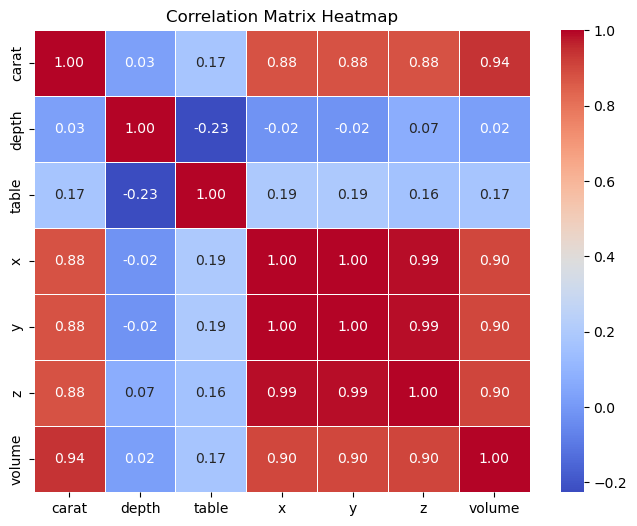

In [41]:
XTR_transf = preproc_pipeline.fit_transform(XTR)

plt.figure(figsize=(8, 6))
sns.heatmap(XTR_transf[num_inputs].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

::: {.callout-note  icon=false}

### A correlation matrix based transformer

We will now implement a transformer that will try to remove at least some collinear variables from the dataset. This transformer is probably the most complex one we will define in this session:
+ It will navigate the correlation matrix one row at a time.
+ If the variable for that row has a *correlation above a certain user selected threshold* with one of the following variables, it will *mark that variable as a candidate for removal*. 
+ The transformer will then *remove all the marked variables*. 

Note that this way *only the first variable in a high correlation pair is considered* for removal due to that pair. This eliminates the risk that the transformer will remove all the variables in a high correlation group.

This is a semiautomatic variable selection method: the only user choice that we will add to this strategy is that *we are allowed to use a predefined ordering of the variables in the dataset*. This allows you to put the variables that you care most about last in the dataset, and the transformer will then first remove the variables that we consider less important in the presence of collinearity. In particular *the last variable in your list will never be selected for removal*.

In this case the collinearity removal transformer is not implemented as a function, but as a transformer class. The class inherits from two scikit classes: `BaseEstimator` and `TransformerMixin`. The first is a base class for all estimators in scikit, and the second is a base class for all transformers. Every estimator class must have a `fit`, and every transformer class needs a `transform` method. By inheriting from these classes we can use the transformer in the pipeline as we have done with the other transformers.

The code below contains some commented print statements that can be uncommented if you want to see the transformer in action. Note finally that the correlation threshold is a candidate to be treated as a hyperparameter to explore in a grid search. 

:::


In [42]:
class DropHighlyCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9, varOrder = None):
        self.threshold = threshold
        self.varOrder = varOrder
        self.original_columns = None
        self._output_format = 'array'  # Default output format

    def fit(self, X, y=None):
        self.original_columns = X.columns
        if self.varOrder is not None:            
            X = X[self.varOrder]
        # Compute the correlation matrix
        # print("column order used here: ", X.columns)
        self.corr_matrix = X.corr().abs()
        return self

    def transform(self, X):
        # Identify columns to drop
        columns_to_drop = set()
        for i in range(len(self.corr_matrix.columns) + 1):
            for j in range(i, len(self.corr_matrix.columns)):
                # print(f"i = {i}, j = {j}, corr = {self.corr_matrix.iloc[i, j]}")
                if j > i and self.corr_matrix.iloc[i, j] > self.threshold:
                    colname = self.corr_matrix.columns[i]
                    # print(f"Column {colname} is highly correlated with {self.corr_matrix.columns[j]} and marked for removal")
                    columns_to_drop.add(colname)
        
        # Drop highly correlated columns
        filtered_data = X[self.original_columns].drop(columns=columns_to_drop)
        
        # If the output format is 'pandas', convert to pandas DataFrame
        if self._output_format == 'pandas':
            return pd.DataFrame(filtered_data, columns=filtered_data.columns)
        
        # Default is to return numpy array
        return filtered_data

    def set_output(self, transform='array'):
        """Allows the user to choose the output format for the transformer."""
        if transform not in ['array', 'pandas']:
            raise ValueError("Output format must be 'array' or 'pandas'")
        self._output_format = transform


::: {.callout-note  icon=false}

### Adding it to the pipeline

Once the transformer class is implemented, we can add it to the pipeline as usual: we create an instance by calling a function called `create_collinearity_remover`, that also allows us to switch off the transformer with a boolean hyperparameter, and to select the threshold for the correlation and the order of the variables. 

Next we create a ColumnTransformer to let the categorical variables pass through unchanged. As usual, we also add a name restoration step to the pipeline and update the pipeline with these two new steps.

:::



In the diamond example we use 0.9 as threshold, and we put `carat` last in the list of variables, because we expect it to be the best predictor of the diamond's price. 

In [43]:
def create_collinearity_remover(use_collinearity_removal = True, threshold=0.9, varOrder = None):
    if use_collinearity_removal:
         return DropHighlyCorrelatedFeatures(threshold=threshold, varOrder=varOrder)
    else:
        return FunctionTransformer(lambda X: X)


In [44]:
use_collinearity_removal  = True
threshold = 0.92

collinearity_remover = create_collinearity_remover(threshold=threshold,     
                                                   varOrder = ['depth', 'table', 'volume', 'z', 'y', 'x', 'carat'], 
                                                #    varOrder = ['x', 'y', 'z', 'carat'], 
                                                   use_collinearity_removal = use_collinearity_removal)
collinearity_remover.set_output(transform='pandas')


remove_collinearity = ColumnTransformer([
    ("collinearRemover", collinearity_remover, num_inputs)
],
    remainder="passthrough")
remove_collinearity.set_output(transform='pandas')


new_steps = [("remove_collinearity", remove_collinearity), 
             ("name_cleanup_collinear", ColumnNameCleaner())
             ]
preproc_pipeline = Pipeline(preproc_pipeline.steps + new_steps)


We can now apply it and see what numerical inputs are left after removing the highly correlated ones.

In [45]:
XTR_transf = preproc_pipeline.fit_transform(XTR)

num_inputs_left = [col for col in XTR_transf.columns if col in num_inputs]
num_inputs_left

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


['carat', 'depth', 'table', 'x']

And we can check the correlation matrix of the remaining numerical variables after the removal of the collinear variables.

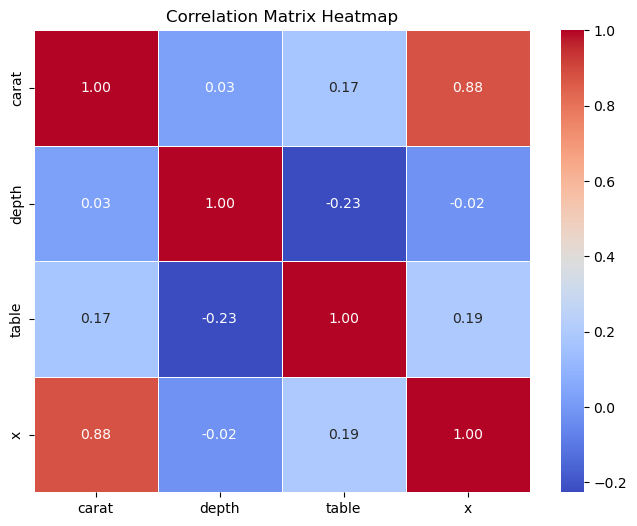

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(XTR_transf[num_inputs_left].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


::: {.callout-warning icon=false}

### Keep track of the variable names and pay attention to a threshold too close to the matrix values

+ This step is different of what we saw with one hot encoding. In that case the total number of variables increased, and the names of the categorical inputs needed to be changed. Here we are dropping variables, but the remaining ones need not change their names in any way. Fortunately, the name restoration transformer that we have been using only depends on the fact that the column transformer adds a prefix to the names of the new variables. 
+ If the threshold you pick is higher than some correlation value but too close to it (e.g. you pick 0.9 and the correlation is 0.88), you have to keep in mind that this preprocessing pipeline will be applied to each fold in a cross validation process. This means that a new correlation matrix will be calculated for each fold and used for variable selection, and the variables that are removed can be different for each of the folds. This can lead to errors in the model fitting as the variables in the training and test sets will not match, or some preprocessing steps downstream in the pipeline will fail because they look for variables that are not there anymore.

:::

## Transformations to increase normality

::: {.callout-note  icon=false}

### Models benefit from normality

Many Machine Learning models behave better when the input variables are normally distributed or at least exhibit some symmetry in their distribution. In particular, hughly skewed variables often have a negative impact on their performance. Therefore it is common practice to apply transformations to the variables to increase their symmetry and sometimes bring them closer to a normal distribution. There are several methods to do this, such as the well known [Box-Cox transformation](https://en.wikipedia.org/wiki/Power_transform#Box–Cox_transformation), the [Yeo-Johnson transformation](https://en.wikipedia.org/wiki/Power_transform#Yeo–Johnson_transformation) or the basic log transformation that the previous one try to generalize. In our pipelne we will use the Yeo-Johnson transformation, because it allows for negative values in the input variables. 

Fortunately in this case our work is made easier by the fact that the `PowerTransformer` transformer from scikit already implements the Yeo-Johnson transformation. Therefore what follows is very similar to what we did for the scaler step, but there is plot twist, because **the current list of variables has changed** after the collinearity removal step. Thus we need to (preferably in a dynamic way) update the list of numerical variables in the pipeline.

:::


In [47]:
use_power_transformer = True

def create_power_transformer(use_power_transformer = use_power_transformer, method='yeo-johnson', standardize=True):
    if use_power_transformer:
         return PowerTransformer(method=method, standardize=standardize) 
    else:
        return FunctionTransformer(lambda X: X)


power_transformer = create_power_transformer(use_power_transformer = True, method='yeo-johnson', standardize=True)
power_transformer.set_output(transform='pandas')


PowerTransformer()

::: {.callout-note  icon=false}

### Dynamically updating the list of numerical variables

This is an added benefit of keeping the variable names unchanged in the pipeline. We can now use the columns of the resulting dataset from a partial preprocessing pipeline to update the list of numerical variables in the pipeline. The following code cell does just this, and then we can define the column transformer and update the pipeline with the transformation step. Recall that we have detected what numerical inputs are left after removing the highly correlated ones.

:::

In [48]:
num_inputs_left

['carat', 'depth', 'table', 'x']

Now the rest of the code is easy:

In [49]:
power_transformed_vars = num_inputs_left

power_transform = ColumnTransformer([
    ("power_transformer", power_transformer, num_inputs_left)
],
    remainder="passthrough")
power_transform.set_output(transform='pandas')


new_steps = [("power_transform", power_transform), 
             ("name_cleanup_power_transform", ColumnNameCleaner())
             ]
preproc_pipeline = Pipeline(preproc_pipeline.steps + new_steps)


And we can check the results of the pipeline up to this point (we only display the numerical variables).

In [50]:
preproc_pipeline.fit_transform(XTR)[num_inputs_left] 

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


carat     depth     table         x
42836 -0.887426  0.439474 -2.441728 -0.820456
9727   1.027965 -1.161257  0.826702  0.974411
35974 -0.848513 -1.079161 -0.631078 -0.787677
22501  0.881213  0.637591  0.826702  0.725116
3571   0.098920  0.055139  1.239508  0.214658
...         ...       ...       ...       ...
50057  0.098920  0.941148  0.826702 -0.041258
32511 -0.926669  2.107540 -0.098001 -0.919689
5192   0.618459  0.839162  2.368765  0.394988
12172  1.131967 -0.130050 -0.631078  0.974411
33003 -1.252285 -0.829356 -0.631078 -1.259743

[43152 rows x 4 columns]

::: {.callout-note  icon=false}

### Review the changes. Slicing a pipeline.

Have we succeeded in making the numerical variables more symmetric? We can check this by plotting density curves for the numerical variables before and after the transformation. 

The `before` plot gives us the opportunity to emphasize that scikit pipelines are a list of steps, and as such can be sliced. This is a very useful feature, as it allows you to jump into a particular pipeline step at any point in your code. Here we use it to slice the pipeline before the power transformation step and apply it to the dataset. This way we can compare the distribution of the variables before and after the transformation.

This can be considered an iterative process, where we check wheter the transformation has managed to bring the variables closer to a normal distribution. If not, we can remove those variables from the list of variables to be transformed, or we can try a different strategy.

:::

In the case of the diamonds dataset, the transformation has managed to make the variables in general slightly more symmetric, but we can see that most of them are still far from a normal distribution. We will leave them as they are for now, but we could try to apply a different transformation to them.

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is

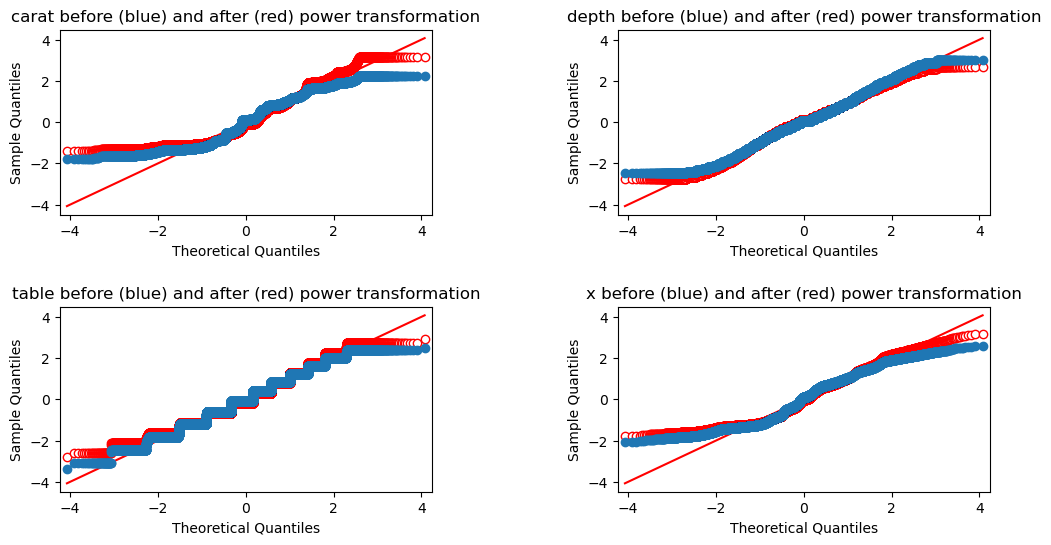

In [51]:
# Number of columns to plot
plot_cols = 2

i = 0
fig, ax = plt.subplots(len(power_transformed_vars) // plot_cols + min(1, len(power_transformed_vars) % plot_cols), 
                       min(len(power_transformed_vars), plot_cols), figsize=(12, 6))

if  len(power_transformed_vars) > 1:
    ax = ax.ravel()[:len(num_inputs_left)] 

for var in power_transformed_vars:   
    # First QQ plot (Before power transformation)
    if  len(power_transformed_vars) > 1:
        u = ax[i]
    else:
        u = ax
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    qqplot_before = sm.qqplot(preproc_pipeline[:-2].fit_transform(XTR)[var], line='s', ax=u)
    qqplot_before_lines = u.get_lines()
    qqplot_before_lines[0].set_markerfacecolor('white')  # Change color to red
    qqplot_before_lines[0].set_markeredgecolor('blue')

    # Second QQ plot (After power transformation)
    qqplot_after = sm.qqplot(preproc_pipeline.fit_transform(XTR)[var],  ax=u)
    qqplot_after_lines = u.get_lines()
    qqplot_after_lines[0].set_markerfacecolor('white')  # Change color to blue
    qqplot_after_lines[0].set_markeredgecolor('red')

    u.set_title(f"{var} before (blue) and after (red) power transformation")
    i += 1

plt.show();plt.close()

In this example it looks like the transformation has not been very successful. We could reconsider applying this transformation in a second visit to the preprocessing pipeline, or we could try a different transformation.

## Adding polynomial features

::: {.callout-note  icon=false}

### Addressing non-linear relationships with polynomial features

For the final step in our preprocessing pipeline for this session we will take a step in the direction of what is usually called **feature engineering**. This is a set of techniques that allow us to create new variables from the existing ones, with the goal of improving the performance of the models, making it easier for them to pick up the signal in the data.

If you look back at the pairplot that we made at the beginning of this session, you will see that some of the numerical variables, and in particular `carat`, show a clear non-linear relationship with the target variable. In cases like this we have already discussed that for certain model types we can try to address this issue by adding polynomial features to the model. 

This method is implemented in scikit with the [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) transformer. Here we will use it to add quadratic terms to the numerical variables in the dataset. The procedure is similar to several previous steps. We will wrap it in a transformer class, proiding it with a list of variables and a polynomial degree, and then we will add it to the pipeline with a boolean hyperparameter that allows us to switch it on and off. 

But we have to be careful with the selection of variables. If you have two variables called, say A and B, the transformer will add all the quadratic terms 
````
A**2, B**2, A * B
````
to the dataset (that is, three new columns). That is fine if you are interested in the interaction between A and B, but if you are not, you need a more nuanced approach. 

There are several different ways to manage this. One of them is to use patsy's formula language, which allows you to specify the terms that you want to include in the model, like we have seen in previous sessions. Another way is to wrap the PolynomialFeatures transformer in a loop that will add the quadratic terms for each variable in the dataset. This is the approach that we will use here.

In this case we are not including a boolean switch because we can simply leave the variable list empty whenever we want to skip this step.

:::

In [52]:
# Leave the list of variables empty to skip this step
poly_vars = ['x']
poly_degrees = [2]

column_transformations = []
for var, degree in zip(poly_vars, poly_degrees):
    var_polfeat = PolynomialFeatures(degree=degree, include_bias=False)
    var_polfeat.set_output(transform='pandas')
    # Here we need a list for the last argument, otherwise it will be considered as a string
    # and pandas in its infinite wisdom will return a Series instead of a DataFrame 
    new_col_transformer = (f"poly_{var}", var_polfeat, [var]) 
    column_transformations.append(new_col_transformer)
    
column_transformations

[('poly_x', PolynomialFeatures(include_bias=False), ['x'])]

In [53]:
polyterms_transform = ColumnTransformer(column_transformations, remainder="passthrough")
polyterms_transform.set_output(transform='pandas')
polyterms_transform


ColumnTransformer(remainder='passthrough',
                  transformers=[('poly_x',
                                 PolynomialFeatures(include_bias=False),
                                 ['x'])])

In [54]:

new_steps = [("add_polyterms", polyterms_transform), 
             ("name_cleanup_polyterms", ColumnNameCleaner())]
preproc_pipeline = Pipeline(preproc_pipeline.steps + new_steps)

preproc_pipeline.fit_transform(XTR)

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


x       x^2     carat     depth     table  cut_Good  cut_Ideal  \
42836 -0.820456  0.673148 -0.887426  0.439474 -2.441728       0.0        1.0   
9727   0.974411  0.949477  1.027965 -1.161257  0.826702       0.0        0.0   
35974 -0.787677  0.620435 -0.848513 -1.079161 -0.631078       0.0        1.0   
22501  0.725116  0.525793  0.881213  0.637591  0.826702       0.0        0.0   
3571   0.214658  0.046078  0.098920  0.055139  1.239508       1.0        0.0   
...         ...       ...       ...       ...       ...       ...        ...   
50057 -0.041258  0.001702  0.098920  0.941148  0.826702       0.0        0.0   
32511 -0.919689  0.845828 -0.926669  2.107540 -0.098001       1.0        0.0   
5192   0.394988  0.156016  0.618459  0.839162  2.368765       0.0        0.0   
12172  0.974411  0.949477  1.131967 -0.130050 -0.631078       0.0        1.0   
33003 -1.259743  1.586952 -1.252285 -0.829356 -0.631078       0.0        1.0   

       cut_Premium  cut_Very Good  color_E  ...  color_H  color_I  color_J  \
42836          0.0            0.0      0.0  ...      0.0      0.0      0.0   
9727           1.0            0.0      0.0  ...      0.0      0.0      0.0   
35974          0.0            0.0      0.0  ...      0.0      0.0      0.0   
22501          1.0            0.0      1.0  ...      0.0      0.0      0.0   
3571           0.0            0.0      1.0  ...      0.0      0.0      0.0   
...            ...            ...      ...  ...      ...      ...      ...   
50057          0.0            1.0      0.0  ...      0.0      1.0      0.0   
32511          0.0            0.0      1.0  ...      0.0      0.0      0.0   
5192           0.0            1.0      0.0  ...      0.0      0.0      0.0   
12172          0.0            0.0      0.0  ...      0.0      0.0      1.0   
33003          0.0            0.0      1.0  ...      0.0      0.0      0.0   

       clarity_IF  clarity_SI1  clarity_SI2  clarity_VS1  clarity_VS2  \
42836         0.0          0.0          0.0          0.0          0.0   
9727          0.0          0.0          1.0          0.0          0.0   
35974         0.0          0.0          0.0          1.0          0.0   
22501         0.0          0.0          0.0          0.0          0.0   
3571          0.0          0.0          0.0          1.0          0.0   
...           ...          ...          ...          ...          ...   
50057         0.0          0.0          0.0          0.0          1.0   
32511         0.0          0.0          1.0          0.0          0.0   
5192          0.0          0.0          0.0          0.0          1.0   
12172         0.0          0.0          0.0          1.0          0.0   
33003         0.0          0.0          0.0          0.0          0.0   

       clarity_VVS1  clarity_VVS2  
42836           1.0           0.0  
9727            0.0           0.0  
35974           0.0           0.0  
22501           1.0           0.0  
3571            0.0           0.0  
...             ...           ...  
50057           0.0           0.0  
32511           0.0           0.0  
5192            0.0           0.0  
12172           0.0           0.0  
33003           1.0           0.0  

[43152 rows x 22 columns]

## The complete preprocessing pipeline. Saving  the pipeline.

::: {.callout-note  icon=false}

### Preprocessing pipelines can be quite complex

We have now completed the preprocessing pipeline for this session. It is quite complex, but it is also quite flexible. We have added several steps to the pipeline, and we have seen how to update the pipeline with new steps. We have also seen how to slice the pipeline to check the results of intermediate steps. If you want to see our final pipeline in its full glory, you can remove the comment in the code cell below.

:::

In [55]:
# preproc_pipeline

Now we use the `dill` library to save the pipeline to a file. This way, we can reuse it in the next session.

In [56]:
import dill

# Assume `pipeline` is your Scikit-learn pipeline


with open("3_3_preproc_pipeline.dill", "wb") as f:
    dill.dump(preproc_pipeline, f)

---

# Regression Models

---


::: {.callout-note  icon=false}

### Different types of regression models and Cross Validation for different models

In the second part of this session we will fit several regression models to dataset, using the preprocessing pipeline that we have just built. We will briefly discuss the theory behind each model type, as most of them are simply the regression version of the classification models that we have seen in previous sessions. 

As usual we will store the results in a dictionary that we will use to compare the models. We also create a dataframe  with the real output valuesfor the test set. This dataframe will store the models predictions and residuals as we obtain them below.

:::

In [57]:
modelDict = {}

dfTS_pred = dfTS[[output]].copy() # Note the double brackets to keep it as a DataFrame instead of a Series
dfTS_pred.columns = ['real']

::: {.callout-note  icon=false}

### Test and validation scores. Cross-validation strategy for model comparison

In order to compare the performance of the models we will use RMSE in the test set as the metric. We will also use a cross validation process to estimate the performance of the models. 

:::

In [58]:
cv = KFold(n_splits=10, shuffle=True, random_state=2025) 

::: {.callout-note  icon=false}

### Model features in and out of the pipeline

We need to identify the feature names coming out of the pipeline in order to pass the rigth names to some of the diagnostic tools that we will use. We will use the `get_feature_names_out` method of the pipeline for this. And we combine that information with the original names of the variables to create some name list to identify the variables in the models.

Note the use of the `named_steps` attribute of the pipeline in the second code cell below to access the transformers in the pipeline. This allows us to get the names of the categorical variables as they come out of the encoding step. 

From this we can also obtain a list of the numerical features at the end of the preprocessing pipeline (including for example the polynomial features that we have added and possibly interactions between the variables). And finally we use it to see which of the original numerical variables are still being used in the model after the preprocessing pipeline.

:::

In [59]:
model_features_out = preproc_pipeline.fit_transform(dfTR[inputs]).columns
model_features_out

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


Index(['x', 'x^2', 'carat', 'depth', 'table', 'cut_Good', 'cut_Ideal',
       'cut_Premium', 'cut_Very Good', 'color_E', 'color_F', 'color_G',
       'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1',
       'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1',
       'clarity_VVS2'],
      dtype='object')

In [60]:
cat_features_preproc = preproc_pipeline.named_steps["encoder"].named_transformers_["ohe"].get_feature_names_out()
num_features_preproc = list(set(model_features_out) - set(cat_features_preproc))
print("Model feature names: ")
print("Categorical features after preprocessing: \n", cat_features_preproc)
print("Numerical features after preprocessing:\n", num_features_preproc)
num_features_model = list(set(num_features_preproc) & set(num_inputs))
print("Original Numerical features used by models:\n", num_features_model,"\n")


Model feature names: 
Categorical features after preprocessing: 
 ['cut_Good' 'cut_Ideal' 'cut_Premium' 'cut_Very Good' 'color_E' 'color_F'
 'color_G' 'color_H' 'color_I' 'color_J' 'clarity_IF' 'clarity_SI1'
 'clarity_SI2' 'clarity_VS1' 'clarity_VS2' 'clarity_VVS1' 'clarity_VVS2']
Numerical features after preprocessing:
 ['carat', 'depth', 'x', 'x^2', 'table']
Original Numerical features used by models:
 ['table', 'depth', 'x', 'carat'] 



In [61]:
model_features_dict = {"num_features_model": num_features_model, 
                         "cat_features_preproc": cat_features_preproc, 
                         "num_features_preproc": num_features_preproc, 
                         "model_features_out": model_features_out}
model_features_dict

{'num_features_model': ['table', 'depth', 'x', 'carat'],
 'cat_features_preproc': array(['cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_E',
        'color_F', 'color_G', 'color_H', 'color_I', 'color_J',
        'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
        'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'], dtype=object),
 'num_features_preproc': ['carat', 'depth', 'x', 'x^2', 'table'],
 'model_features_out': Index(['x', 'x^2', 'carat', 'depth', 'table', 'cut_Good', 'cut_Ideal',
        'cut_Premium', 'cut_Very Good', 'color_E', 'color_F', 'color_G',
        'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1',
        'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1',
        'clarity_VVS2'],
       dtype='object')}

## Linear Regression

::: {.callout-note  icon=false}

### Linear Regression as a baseline

Almost every regression modeling problem should start with a linear regression model. It is a simple model that is easy to interpret, and it can give you a good idea of the performance that you can expect from the more complex models. We consider it a baseline model (like logistic regression in classification problems) and we will use it as a reference to compare the performance of the other models: if you can not beat the linear regression model, there is probably no reason to use fancier, more complex models.

The fitting process for most models begins by:  
  
1. instantiating the model class (a scikit class usually),   
</br>  
2. adding it to a pipeline, whose first step is the preprocessing pipeline that we have built,  
</br>  
3. fitting the model to the training data.  
</br>

For this model we use the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class from scikit that we have already seen in the previous sessions (we could use a statsmodels model as well, but we will stick to scikit for simplicity).

:::

In [62]:
LM = LinearRegression()

LM_pipe = Pipeline([
    ("preprocessor", preproc_pipeline),
    ("LM", LM)
])

model_name = "LM"
model = LM_pipe

Next we fit the model

In [63]:
model_fit = model.fit(XTR, YTR)

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


::: {.callout-note  icon=false}

### Predictions of the model

With a fitted model we are ready to make predictions for the test set, and store the predictions and residual in the dataframe we created for that purpose.



:::

In [64]:
model_prediction = model.predict(XTS)

dfTS_pred[model_name + 'fitted'] = model.predict(XTS)
dfTS_pred[model_name + 'resid'] = YTS.values - dfTS_pred[model_name + 'fitted']

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


::: {.callout-note  icon=false}

### Getting the test and validation scores of the model.

Getting the test score of the model is as simple as calculating the RMSE of the predictions. 

The computation of validation score is special in the case of the linear model, because we have not used cross validation to fit this model. It has no hyperparameters to tune, and it is a simple model that is not likely to overfit the training data. Therefore we will mow run a cross validation process, using the `cross_val_score` function from scikit, with the `scoring` argument to specify that we want to use the RMSE as the metric. This will provide us with an idea of how robust model predictions are against changes in the training data. We change the sign of the scores to make them positive, as the `cross_val_score` function returns the negative RMSE.

Note also that we use the cv argument to make sure that the cross validation process uses the same folds as the other models, as we discussed before. 


:::

In [65]:
model_rmse = root_mean_squared_error(YTS, model_prediction)
print("model test rmse = ", model_rmse)

model_validation_scores = - cross_val_score(model, XTR, YTR, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
print("model validation scores = ", -model_validation_scores)


model test rmse =  0.142513858560863


/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is

model validation scores =  [-0.1364112  -0.14627747 -0.15943901 -0.14704767 -0.14055451 -0.15763279
 -0.14373672 -0.14814428 -0.13902563 -0.15179048]


::: {.callout-note  icon=false}

### Storing the model and its information

Now we add the model and its scores to the dictionary of models that we will use to compare the performance of the models.

:::

In [66]:
modelDict[model_name] = {'model': model}
modelDict[model_name]["RMSE"] = model_rmse
modelDict[model_name]["validation_scores"] = model_validation_scores

::: {.callout-note  icon=false}

### Residual Plots

We will get the residuals plots for this model against the numerical inputs. Recall that in the case of a good model fit we expect the residuals to be randomly distributed around zero, and not to show any pattern.

**Note:** use the `show_categorical_residual_plots` boolean values to decide whether to get boxplots of the residuals against the categorical variables levels.

:::

In [67]:
%run -i "./3_4_ResidualPlots.py"

In this case we leave `show_categorical_residual_plots = False` after checking that the boxplots shoow no relationship between the residuals and the categorical variables.

--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['table', 'depth', 'x', 'carat']
--------------------------------------------------


/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


[<Axes: > <Axes: >]


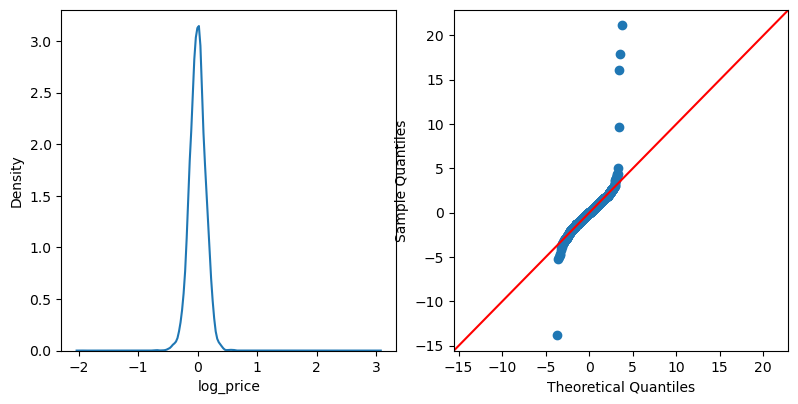

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


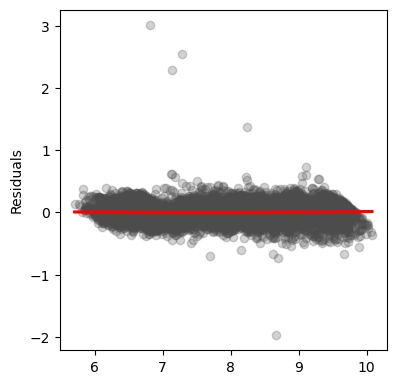

--------------------------------------------------
Numerical inputs: ['table', 'depth', 'x', 'carat']
--------------------------------------------------


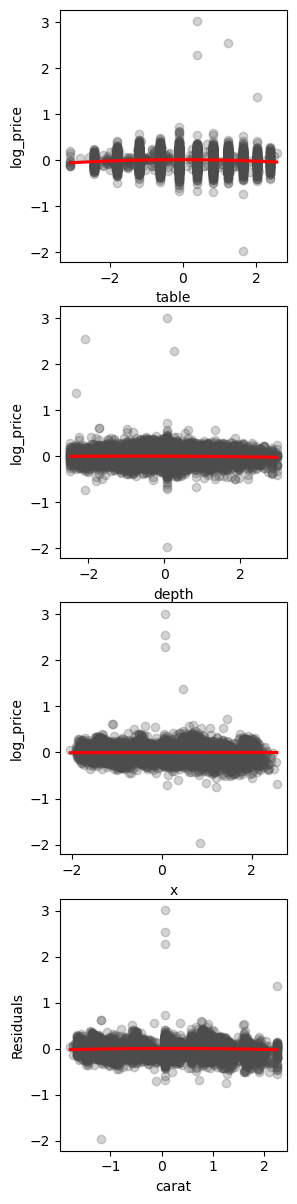

--------------------------------------------------
No categorical inputs provided.
--------------------------------------------------


In [68]:
show_categorical_residual_plots = False
if show_categorical_residual_plots:
    ResidualPlots(model = model, X = XTS, Y = YTS, num_inputs = num_features_model, cat_inputs = cat_features_preproc)   
else:
    ResidualPlots(model = model, X = XTS, Y = YTS, num_inputs = num_features_model)


::: {.callout-note  icon=false}

### Fitted against Real values

Another interesting plot is the scatter plot of the real values against the fitted values. In the case of a good model fit we expect the points to be close to the line $y = x$. Any pattern showing a deviation from this line indicates that the model is not doing a good job at capturing the signal in the data.

:::

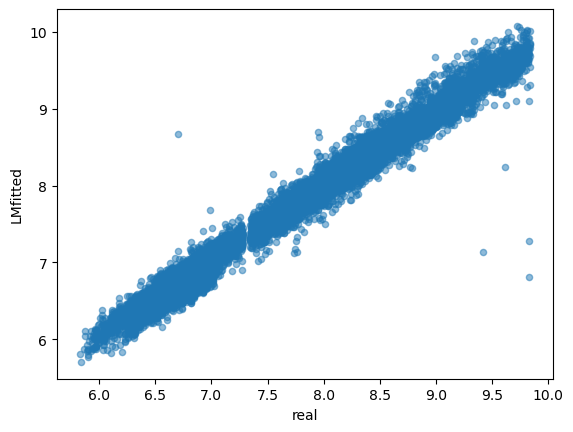

In [69]:
dfTS_pred.plot.scatter(x='real', y=model_name + 'fitted', alpha=0.5)
plt.show();plt.close()

## KNN for regression

::: {.callout-note  icon=false}

### Using KNN for regression

The idea of the KNN model that we have seen in the classification part of the course can be easily extended to regression problems. The simplest version of the model predicts the output value of an instance by computing the average of the output values of the k nearest neighbors of that instance. Different variants of the model can be used, such as the weighted average of the output values of the neighbors, where the weights are inversely proportional to the distance of the neighbors to the instance. And the averaging itself can be done in different ways, such as the median of the output values of the neighbors. Furthermore, as is always the case with KNN, the choice of the distance metric is crucial, and usually expert knowledge is useful in making the right choice.

Scikit provides the [`KNeighborsRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) class for this model. As we know, the number of neighbors k, is a hyperparameter of the model that can be tuned in a grid search.


:::

We begin by instantiating the model:

In [70]:
KNN = KNeighborsRegressor() 

::: {.callout-note  icon=false}

### Cross Validation for KNN

We will see now that after fitting the linear model, adding a new model to the pipeline is essentially the same process. The main difference in the case of KNN is that we will use a grid search to tune the hyperparameter k of the model.


We need to define: 
+ The modeling pipeline (that will be added at the end of the preprocessing pipeline), 
+ The hyperparameter grid dictionary,
+ The grid search object. 

We will use the `GridSearchCV` class from scikit to perform the grid search. The grid search will be performed using the RMSE as the scoring metric, and we will use the same cross validation strategy as before to make the model comparison fair.

:::

In [71]:
hyp_grid = {'KNN__n_neighbors': range(2, 15)}

KNN_pipe = Pipeline([
    ("preprocessor", preproc_pipeline),
    ("KNN", KNN)
])

KNN_gridCV = GridSearchCV(estimator=KNN_pipe, 
                        param_grid=hyp_grid, 
                        cv=cv, # Use the same cross-validation as before
                        scoring='neg_root_mean_squared_error',
                        return_train_score=True,
                        n_jobs=-1)

model_name = "KNN"
model = KNN_gridCV

Now we are ready to fit the model

In [72]:
%time
model_fit = model.fit(XTR, YTR)

CPU times: user 10 μs, sys: 0 ns, total: 10 μs
Wall time: 19.6 μs


/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is

After a hyperparameter search we should always check the hyperparameters of the selected model to see if they are on the boundary of our search grid. This can be done with the `best_params_` attribute of the grid search object.

In [73]:
model.best_params_

{'KNN__n_neighbors': 6}

We can get the model test predictions:

In [74]:
model_prediction = model.predict(XTS)
dfTS_pred[model_name + 'fitted'] = model_prediction
dfTS_pred[model_name + 'resid'] = YTS.values - model_prediction

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


And use it to get the model test score. 


In [75]:
model_rmse = root_mean_squared_error(YTS, model_prediction)
model_rmse

0.1589102692418686

As for the validation score, in this case we do not use the `cross_val_score` function. Instead, we use the `cv_results_` attribute of the grid search object to get the cross validation results.

All the possible hyperparameters combinations are assigned an index in the grid search. And the one used for the final selected model is identified by the `best_index_` attribute of the grid search object. We can use this index to get the validation scores of the model for all the folds and for that particular hyperparameter combination.

In [76]:
best_index = model.best_index_
n_splits = model.n_splits_
model.cv_results_['mean_test_score'][best_index]
model_validation_scores_array = np.array([model.cv_results_[f'split{i}_test_score'] for i in range(n_splits)])
model_validation_scores = np.abs(model_validation_scores_array[:, best_index])
model_validation_scores

array([0.16163138, 0.16466777, 0.16989772, 0.16291871, 0.16570249,
       0.17265009, 0.16810382, 0.16410384, 0.15442386, 0.1696145 ])

We are now ready to add this model information to the dictionary of models.

In [77]:
modelDict[model_name] = {"model" : model, "RMSE": model_rmse, "validation_scores": model_validation_scores}

We can also do the residual plots for this model.

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['table', 'depth', 'x', 'carat']
--------------------------------------------------
[<Axes: > <Axes: >]


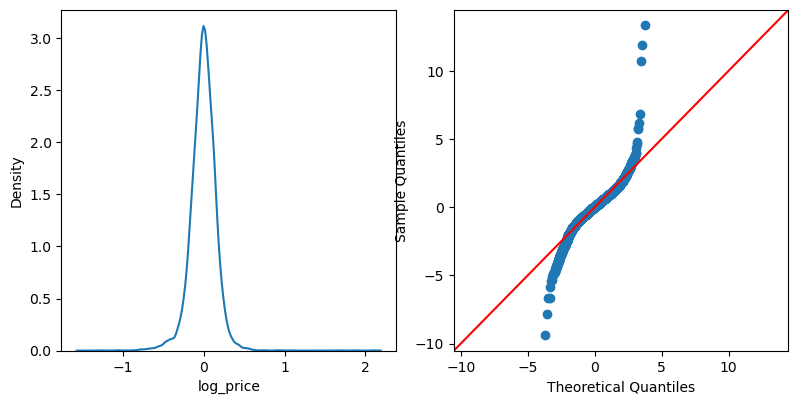

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


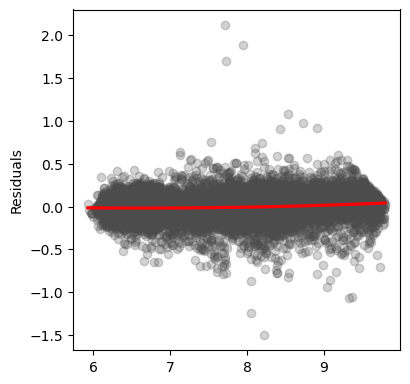

--------------------------------------------------
Numerical inputs: ['table', 'depth', 'x', 'carat']
--------------------------------------------------


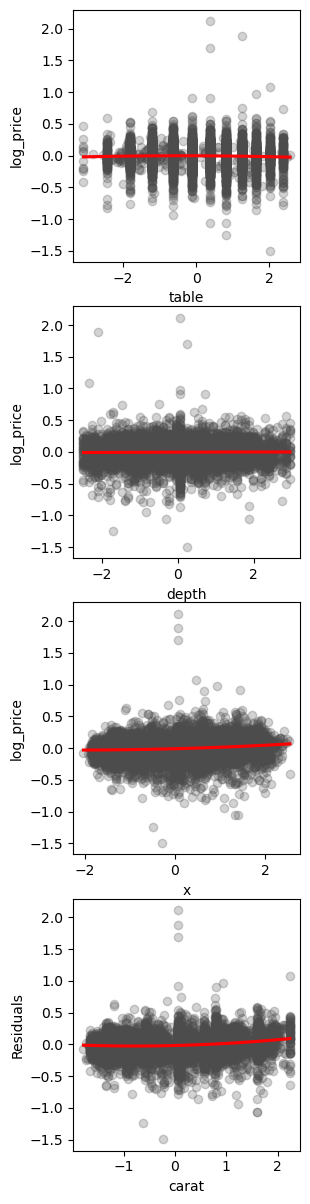

--------------------------------------------------
No categorical inputs provided.
--------------------------------------------------


In [78]:
show_categorical_residual_plots = False
if show_categorical_residual_plots:
    ResidualPlots(model = model, X = XTS, Y = YTS, num_inputs = num_features_model, cat_inputs = cat_features_preproc)   
else:
    ResidualPlots(model = model, X = XTS, Y = YTS, num_inputs = num_features_model)


## Random Forest

::: {.callout-note  icon=false}

### More regression model examples

In this and the following sections we will fit several additional regression models to the dataset. We will not discuss the theory behind each model type in detail, as most of them are simply the regression version of the classification models that we have seen in previous sessions. We will streamline the process of fitting the models, and we will only add some comments when some property of the model under consideration is different from the models that we have seen before.

:::

We instantiate the model. Note that we keep a fixed number of trees in the forest, and also a fixed strategy for the number of variables to be considered at each split. These could also be used as hyperparameters to be tuned in a grid search, but we will limit the searcch to some tree complexity parameters. 

In [79]:
RF =RandomForestRegressor(random_state=2025, max_features="sqrt", n_estimators=500)

In [80]:
hyp_grid = {'RF__min_samples_leaf': range(10, 150, 10),
            'RF__max_depth': range(1, 5)}

RF_pipe = Pipeline([
    ("preprocessor", preproc_pipeline),
    ("RF", RF)
])

RF_gridCV = GridSearchCV(estimator=RF_pipe,
                         param_grid=hyp_grid,
                         cv=cv, # Use the same cross-validation as before
                         return_train_score=True,
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1)

model_name = "RF"
model = RF_gridCV

From this point on the process is the same as for the KNN model, we can copy the code cells we used there:

In [81]:
%time
model_fit = model.fit(XTR, YTR)

CPU times: user 10 μs, sys: 1 μs, total: 11 μs
Wall time: 20.3 μs


/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is

**The fit time for this grid search was about 6 minutes in my laptop.** Keep this in mind when you are running the code. Besides, the selected hyperparameters are located in extreme values of the search grid. This is an indication that we may need to expand the search grid to find the best hyperparameters for the model. We leave this as an exercise for you.

In [82]:
model.best_params_

{'RF__max_depth': 4, 'RF__min_samples_leaf': 10}

In [83]:
model_prediction = model.predict(XTS)
dfTS_pred[model_name + 'fitted'] = model_prediction
dfTS_pred[model_name + 'resid'] = YTS.values - model_prediction

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Note that the test score of this model is much worse than for the other models 

In [84]:
model_rmse = root_mean_squared_error(YTS, model_prediction)
model_rmse

0.3892531276485577

In [85]:
best_index = model.best_index_
n_splits = model.n_splits_
model.cv_results_['mean_test_score'][best_index]
model_validation_scores_array = np.array([model.cv_results_[f'split{i}_test_score'] for i in range(n_splits)])
model_validation_scores = np.abs(model_validation_scores_array[:, best_index])
model_validation_scores

array([0.39396567, 0.38981564, 0.39272954, 0.38942746, 0.38572592,
       0.39215863, 0.38915415, 0.39312798, 0.39489274, 0.39080054])

We are now ready to add this model information to the dictionary of models.

In [86]:
modelDict[model_name] = {"model" : model, "RMSE": model_rmse, "validation_scores": model_validation_scores}

We can also do the residual plots for this model.

**Note in this case that the residuals show a clear pattern against some numerical variables. This is an indication that the model is not capturing the signal in the data.**

This probably means that we need to add more complexity to the trees in the random forest and maybe we should remove some of the least useful variables. We have already left it as an exercise to expand the search grid for the hyperparameters of the model. We can also try to add more trees to the forest (that will increase the model fitting time) and see if the model performance improves.

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['table', 'depth', 'x', 'carat']
--------------------------------------------------
[<Axes: > <Axes: >]


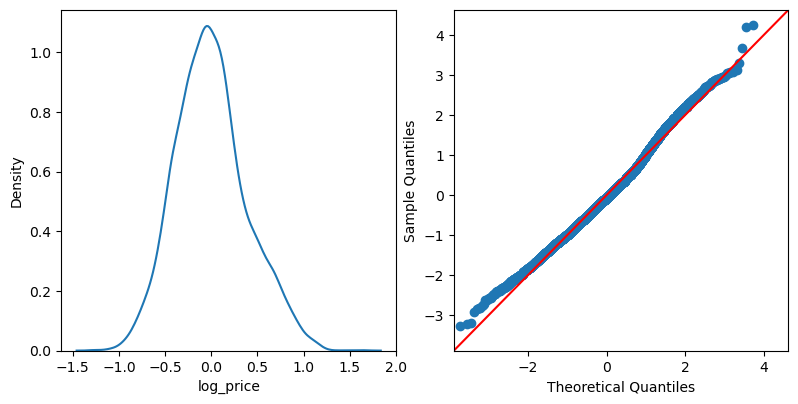

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


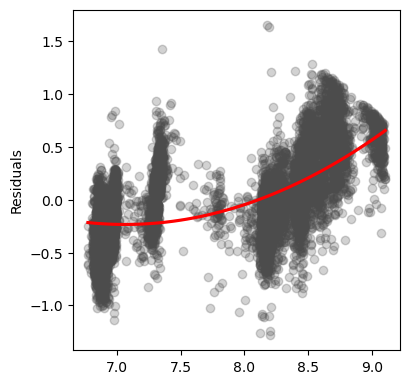

--------------------------------------------------
Numerical inputs: ['table', 'depth', 'x', 'carat']
--------------------------------------------------


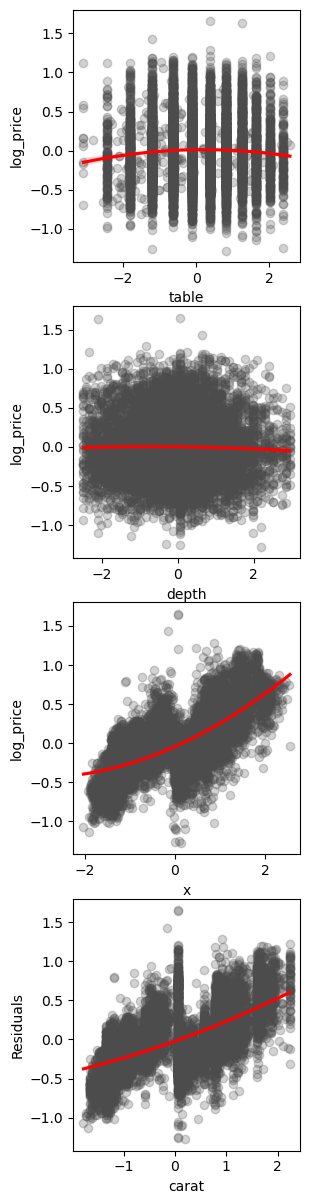

--------------------------------------------------
No categorical inputs provided.
--------------------------------------------------


In [87]:
show_categorical_residual_plots = False
if show_categorical_residual_plots:
    ResidualPlots(model = model, X = XTS, Y = YTS, num_inputs = num_features_model, cat_inputs = cat_features_preproc)   
else:
    ResidualPlots(model = model, X = XTS, Y = YTS, num_inputs = num_features_model)


::: {.callout-note  icon=false}

### Variable importance in Random Forest

One of the nice properties of tree based models such as Random Forest is that they naturally provide a measure of the importance of the variables in the model, as we have seen in previous sessions. We can use the `feature_importances_` attribute of the model to get this information. 

:::

**We would normally use this information to judge the importance of the variables in the model and maybe fit a second refined model. But keep in mind that if the model fit seems underfitted, we should not rely much on the variable importances assigned by the model.**

In [88]:
var_importances = pd.DataFrame({'var':model_features_out, 
                                'importance': model.best_estimator_.named_steps["RF"].feature_importances_}
                                ).sort_values(by="importance", ascending = False)
var_importances

var  importance
2           carat    0.420319
0               x    0.411894
1             x^2    0.108460
17    clarity_SI2    0.016212
4           table    0.014747
20   clarity_VVS1    0.006402
6       cut_Ideal    0.004651
9         color_E    0.003552
21   clarity_VVS2    0.003246
7     cut_Premium    0.002566
13        color_I    0.001808
14        color_J    0.001618
15     clarity_IF    0.001013
16    clarity_SI1    0.000944
12        color_H    0.000782
3           depth    0.000659
8   cut_Very Good    0.000532
18    clarity_VS1    0.000174
19    clarity_VS2    0.000135
5        cut_Good    0.000121
11        color_G    0.000098
10        color_F    0.000066

## Gradient Boosting

::: {.callout-note  icon=false}

### Quick fit of a Gradient Boosting model

For this case we just repeat the basic scheme that we have used for the previous models, and we jump straight to the performance evaluation of the model.

:::

**Note the use of [np.logspace](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html) to define the search grid for the learning rate hyperparameter. This is a common practice when you are not sure about the scale of the hyperparameter values that you should use.**

In [89]:
HGB = HistGradientBoostingRegressor(random_state=2025)

hyp_grid = {'HGB__max_iter': [100, 200, 300],
            'HGB__learning_rate': np.logspace(-2, 0, num=5),
            'HGB__max_depth': range(1, 6, 2)}

HGB_pipe = Pipeline([
    ("preprocessor", preproc_pipeline),
    ("HGB", HGB)
])

HGB_gridCV = GridSearchCV(estimator=HGB_pipe, 
                        param_grid=hyp_grid, 
                        cv=cv, # Use the same cross-validation as before
                        scoring='neg_root_mean_squared_error',
                        return_train_score=True,
                        n_jobs=-1)

model_name = "HGB"
model = HGB_gridCV  

**This grid search took about 3 minutes in my laptop.**

In [90]:
%time
model.fit(XTR, YTR);

CPU times: user 22 μs, sys: 0 ns, total: 22 μs
Wall time: 42.4 μs


/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is

In [91]:
model.best_params_

{'HGB__learning_rate': np.float64(0.31622776601683794),
 'HGB__max_depth': 5,
 'HGB__max_iter': 300}

**Again, a better and wider grid search space should be explored.**

In [92]:
model_prediction = model.predict(XTS)
dfTS_pred[model_name + 'fitted'] = model_prediction
dfTS_pred[model_name + 'resid'] = YTS.values - model_prediction

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Note however that this is the best test score so far, and the validation scores seem to indicate that the model is not overfitting.

In [93]:
model_rmse = root_mean_squared_error(YTS, model_prediction)
model_rmse

0.10296970540520008

In [94]:
best_index = model.best_index_
n_splits = model.n_splits_
model.cv_results_['mean_test_score'][best_index]
model_validation_scores_array = np.array([model.cv_results_[f'split{i}_test_score'] for i in range(n_splits)])
model_validation_scores = np.abs(model_validation_scores_array[:, best_index])
model_validation_scores

array([0.1030028 , 0.10612312, 0.10967362, 0.10605182, 0.10080001,
       0.1186434 , 0.10820252, 0.10920175, 0.10161146, 0.11009395])

In [95]:
modelDict[model_name] = {"model" : model, "RMSE": model_rmse, "validation_scores": model_validation_scores}

The residual plots for this model also seem to indicate that is doing a good job at capturing the signal in the data.

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['table', 'depth', 'x', 'carat']
--------------------------------------------------
[<Axes: > <Axes: >]


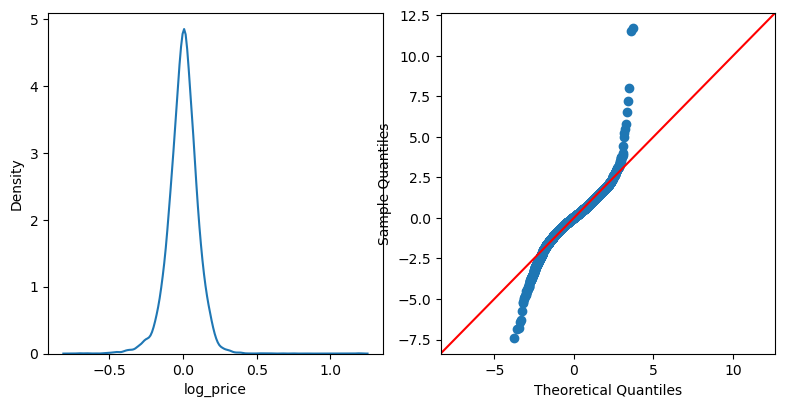

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


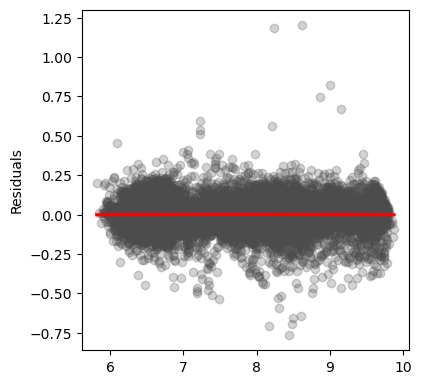

--------------------------------------------------
Numerical inputs: ['table', 'depth', 'x', 'carat']
--------------------------------------------------


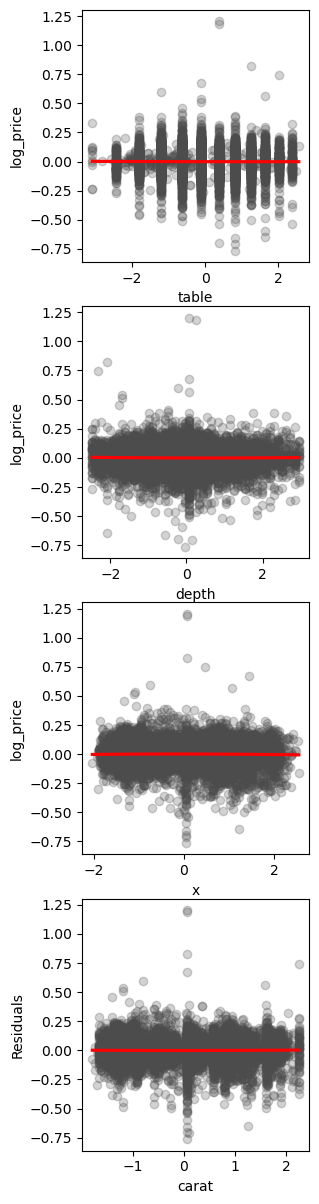

--------------------------------------------------
No categorical inputs provided.
--------------------------------------------------


In [96]:
show_categorical_residual_plots = False
if show_categorical_residual_plots:
    ResidualPlots(model = model, X = XTS, Y = YTS, num_inputs = num_features_model, cat_inputs = cat_features_preproc)   
else:
    ResidualPlots(model = model, X = XTS, Y = YTS, num_inputs = num_features_model)


### Feature importance in Gradient Boosting through Permutation Importance (and other Machine Learning models)

::: {.callout-note  icon=false}

### What is permutation importance?

The `HistGradientBoostingRegressor` class does not provide a direct measure of feature importance like the `RandomForestRegressor` class does. But we can use other methods available in scikit to get an idea of the importance of the variables in the model, such as the `permutation_importance` function. Permutation importance is a model-agnostic method. This means it can be applied to any machine learning model (not just HistGradientBoostingRegressor). This is thanks to the fact that this method does not depend on the internal workings of the model. Instead, it works by shuffling each feature and measuring the impact on performance. This idea can be aplied to any regression or classification model. 
To get the feature permutation importance we take ine of the input features at a time and we shuffle it while keeping the others unchanged. Then we use the model to make predictions on this shuffled dataset, and measure the performance. The expected drop in performance indicates the importance of the shuffled feature. After repeating this shuffling/reevaluation processa a given number of times (10 is a typical value) we can get an average importance for each feature. 


:::

In [97]:
perm_importance = permutation_importance(model, XTS, YTS, n_repeats=10, random_state=2025)

feature_importance_df = pd.DataFrame({
    'Feature': [var for var in XTS.columns],
    'Importance': perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)
feature_importance_df

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipe

Feature  Importance
3        x    0.650358
0    carat    0.642717
9  clarity    0.146265
8    color    0.080565
7      cut    0.007182
1    depth    0.006186
2    table    0.001761
4        y    0.000000
5        z    0.000000
6   volume    0.000000

## Support Vector Machines for regression

::: {.callout-note  icon=false}

### Support Vector Machines and large datasets

Support Vector Machines are a powerful model that can be used for both classification and regression problems. They are particularly useful when the number of features is large, and the number of instances is small. In our case the situation is reversed, and we have a small number of features and a large number of instances. This is not a good situation for SVM models, because in such cases their training time can be very long (in the diamond dataset with radial kernel it went over 1h of training time; compare it with the other models above). 

In a case like this, if we want to use an SVM model, we can try to use a simpler linear kernel (much faster than the radial kernel). Still, even with the linear kernel, the training time for our dataset is too long. Therefore we will use a subsample of the training data to perform the grid search for the hyperparameters of the model. After selecting promising hyperparameters, we will fit the model to the full training data.

Even with this subsampling, the grid search for the hyperparameters of the model will take a long time (over 20 minutes for the diamond dataset). Therefore the code cells for the SVM model are commented and we recommend that you run them only when considering a smaller dataset or when time is not pressing.

:::

In [109]:
from sklearn.svm import SVR


SVM = SVR(kernel='linear', C=1, epsilon=0.1)

hyp_grid = {'SVM__C': [1, 10, 100, 1000],
            'SVM__epsilon': [1, 0.5, 0.1, 0.01]}

SVM_pipe = Pipeline([
    ("preprocessor", preproc_pipeline),
    ("SVM", SVM)
])

SVM_gridCV = GridSearchCV(estimator=SVM_pipe, 
                        param_grid=hyp_grid, 
                        cv=cv, # Use the same cross-validation as before
                        scoring='neg_root_mean_squared_error',
                        return_train_score=True,
                        n_jobs=-1)

model_name = "SVM_linear"
model = SVM_gridCV  

We create the subsample of the training data, a (reproducible!) 10% of the training data in this case.  

In [110]:
gridSearch_sample_size = int(np.floor(XTR.shape[0]*0.1))
gridSearch_sample_size
gridSearch_sample_idx = np.random.default_rng(seed=2025).choice(XTR.shape[0], gridSearch_sample_size, replace=False).tolist()


And use it to perform the grid search for the hyperparameters of the model. **This grid search took about 6 minutes in my laptop (even with a subsampled training set).**

In [ ]:
# smallXTR = XTR.iloc[gridSearch_sample_idx]
# smallYTR = YTR.iloc[gridSearch_sample_idx]

# smallSVM = SVM_gridCV.fit(smallXTR, smallYTR)

# smallSVM.best_params_


/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is

{'SVM__C': 100, 'SVM__epsilon': 0.1}

**Note that the selected values of one of the hyperparameters is at the boundary of the search grid.** We may need to expand the search grid to find the best hyperparameters for the model.

In [ ]:
# SVM_pipe = Pipeline([
#     ("preprocessor", preproc_pipeline),
#     ("SVM", SVR(kernel='poly', 
#                 C=smallSVM.best_params_['SVM__C'], 
#                 epsilon=smallSVM.best_params_['SVM__epsilon'],
#                 degree=2))
# ])

# model_name = "SVM"
# model = SVM_pipe

# model.fit(XTR, YTR);

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


**The model fit took an additional 30 minutes!**

Now the rest of the sequence is the same as for the previous models.

In [ ]:
# model_prediction = model.predict(XTS)
# dfTS_pred[model_name + 'fitted'] = model_prediction
# dfTS_pred[model_name + 'resid'] = YTS.values - model_prediction

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [ ]:
# model_rmse = root_mean_squared_error(YTS, model_prediction)
# model_rmse

0.136561636514696

In [ ]:
# modelDict[model_name] = {"model" : model, "RMSE": model_rmse}


The residual plots for this model also seem to indicate that is doing a good job at capturing the signal in the data.

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/conda/envs/mlmiin/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['table', 'depth', 'x', 'carat']
--------------------------------------------------
[<Axes: > <Axes: >]


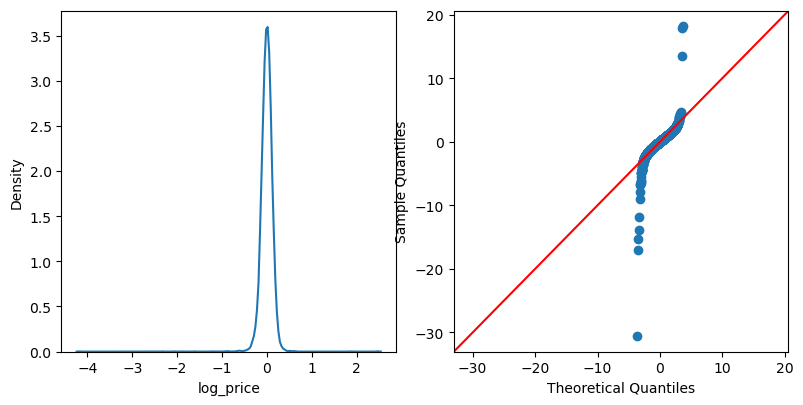

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


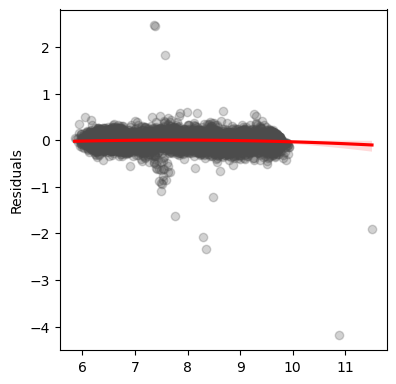

--------------------------------------------------
Numerical inputs: ['table', 'depth', 'x', 'carat']
--------------------------------------------------


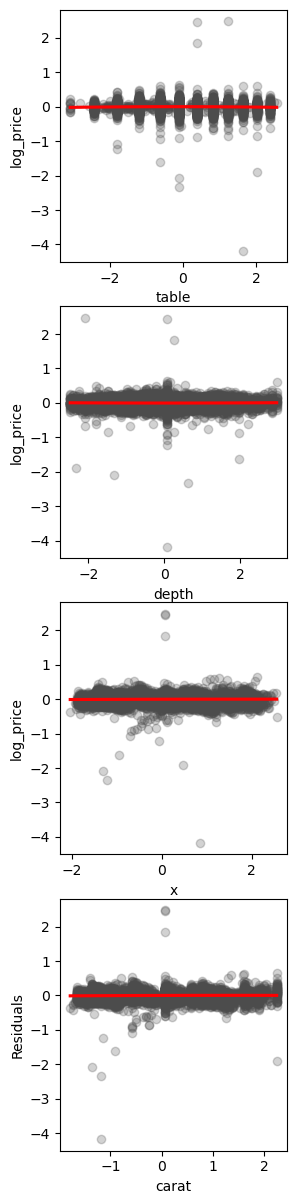

--------------------------------------------------
No categorical inputs provided.
--------------------------------------------------


In [ ]:
# show_categorical_residual_plots = False
# if show_categorical_residual_plots:
#     ResidualPlots(model = model, X = XTS, Y = YTS, num_inputs = num_features_model, cat_inputs = cat_features_preproc)   
# else:
#     ResidualPlots(model = model, X = XTS, Y = YTS, num_inputs = num_features_model)


## Model Comparison

::: {.callout-note  icon=false}

### Model comparison criteria

The simplest approach to compare regression models is to look at the RMSE of the models in the test set. But this simple reductionist approach can sometimes be misleading because of, among other reasons:
- the test set is a small sample of the data, and the RMSE can vary from one sample to another. 
- there are other criteria that lead us to prefer one model over another, such as the complexity of the model, the interpretability of the model, the time it takes to fit the model, and the time it takes to make predictions with the model.

To address the first concern we should also look at the cross validation scores of the models, as they provide a more robust estimate of the performance of the models. To address the second concern we should look at the models in a more holistic way, and consider all the criteria that we have mentioned.

:::

The code below provides a summary of the test scores of the models (ordered by increasing error). In terms of this metric the Gradient Boosting model is clearly the best one, followed by the SVM model. 

In [118]:
model_df = modelDict.copy()
model_df  = pd.DataFrame({'model': model_df.keys(), 'RMSE':[model_df[k]['RMSE'] for k in model_df.keys()]})
model_df.sort_values(by='RMSE', ascending=True)

model      RMSE
3   HGB  0.102970
4   SVM  0.136562
0    LM  0.142514
1   KNN  0.158910
2    RF  0.389253

From this overly simplistic point of view, the Gradient Boosting model is the best one. Let us examine the cross validation scores of the models using boxplots. In order to do that we create an auxiliary dataframe with the cross validation scores of the models.

In [122]:
modelDict.keys()


dict_keys(['LM', 'KNN', 'RF', 'HGB', 'SVM'])

In [123]:

val_scores = {ml:(modelDict[ml])['validation_scores'] for ml in modelDict.keys() if 'validation_scores' in modelDict[ml].keys()}
model_val_scores = pd.DataFrame(val_scores)
# model_val_scores.head()


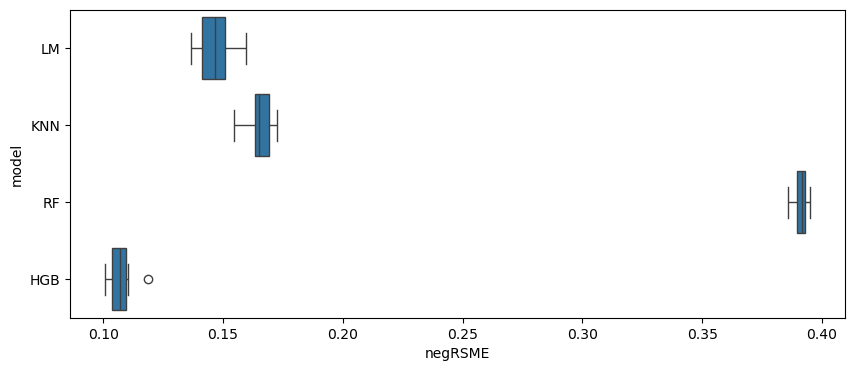

In [124]:
metric = "negRSME"
fig = plt.figure(figsize=(10, 4))
sns.boxplot(model_val_scores.melt(var_name="model", value_name=metric), x=metric, y ="model");


This plot confirms some of the conclusions that we have drawn from the test scores, and shows that they do not depend on the particular sample of the data that we have used for the test set. The Gradient Boosting model seems to be the best one, followed by the linear model (remember, with some quadratic term). The Random Forest model is consistently the worst one in terms of the cross validation scores (it really would need training with a better hyperparameter grid).

The gap between the Gradient Boosting model and the other models is sizeable, and its training time is not too long. Therefore we can consider it the best model for this dataset. However, if interpretability is a concern, the linear model is a good second  alternative and the difference in performance is not that big.

---

# References